In [1]:
from backend.utils import *
import pandas as pd
from datetime import datetime, timedelta
import geemap
import ee
import numpy as np
from sklearn.linear_model import HuberRegressor
import os
from scipy import interpolate
from scipy.interpolate import griddata
from skimage.metrics import structural_similarity as ssim
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import proplot as pplt
import glob
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from PlumeNet import *
import numpy as np
from radtran import setup
import radtran.radtran as rt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pnet_model = PlumeNet(6, 1, n_classes=1).to(device)
pnet_models_weights = glob.glob('model_weights/*.h5')

In [3]:
def get_plume(lon, lat, startDate, endDate, dX=1.5, dY=1.5, do_retrieval=False, satellite='L8'):
    """
    dX/dY: distance (km) in NS/WE direction
    lon: longitude (~180 -- 180)
    lat: latitude
    startDate/endDate: string ('YYYY-MM-DD') for initial/final date
    do_retrieval: flag for calculating XCH4 using the MBSP approach
    satellite: Satellite name (L4, L5, L7, L8, and S2) 
    """
    
    # Initialize Earth Engine
    ee.Initialize()

    # Coordinate mapping for rectangle of plume
    grid_pt = (lat, lon)
    dlat = dY/110.574
    dlon = dX/111.320/np.cos(lat*0.0174532925)
    #print('dlat, dlon: ', dlat, dlon)
    W=grid_pt[1]-dlon 
    E=grid_pt[1]+dlon
    N=grid_pt[0]+dlat
    S=grid_pt[0]-dlat
    re   = ee.Geometry.Point(lon, lat)
    region = ee.Geometry.Polygon(
        [[W, N],\
        [W, S],\
        [E, S],\
        [E, N]])

    era5_region = ee.Geometry.Polygon(
            [[lon-0.01, lat+0.01],\
              [lon-0.01, lat-0.01],\
              [lon+0.01, lat-0.01],\
              [lon+0.01, lat+0.01]])

    

    redband = satellite_database[satellite]['Red']
    greenband = satellite_database[satellite]['Green']
    blueband = satellite_database[satellite]['Blue']
    nirband = satellite_database[satellite]['NIR']
    swir1band = satellite_database[satellite]['SWIR1']
    swir2band = satellite_database[satellite]['SWIR2']
    cloudband = satellite_database[satellite]['Cloud']
    foldername = satellite_database[satellite]['Folder']

    # Pull the desired collection; filter date, region and bands
    # filterMetaData allows us to pick the desired Grid Reference System. Since the images appeared identicle, I picked 31SGR...
    # If the other MGRS is better, we can remove filterMetadata, reprint, and pick the other. 
    if satellite == 'Sentinel-2':
        _default_value = None
        scaleFac = 0.0001
        img_collection = get_s2_cld_col(region, startDate, endDate)  # Oct10 tlh: change to tiles covering the central point only
        if img_collection is not None:
            img_collection = img_collection.map(add_cloud_bands).select([redband,
                                            greenband,
                                            blueband,
                                            nirband,
                                            swir1band,
                                            swir2band,
                                            'cloud_prob'])
    else:
        _default_value = -999.0
        scaleFac = 1

        # Oct10 tlh: change to tiles covering the central point only
        img_collection = ee.ImageCollection('LANDSAT/%s'%foldername).filterDate(startDate, endDate).filterBounds(region).select([redband,
                                                                        greenband,
                                                                        blueband,
                                                                        nirband,
                                                                        swir1band,
                                                                        swir2band,
                                                                        cloudband])

    # initialize arrays
    chanlarr = None
    zarr = None
    lonarr = None
    latarr = None
    date_list2 = []
    u10m, v10m = [], []

    if img_collection is None:
        id_list, date_list = [], []
        pass

    # convert to list of images
    collectionList = img_collection.toList(img_collection.size())



    if img_collection.size().getInfo() == 0:
        id_list, date_list = [], []
        pass
    else:
        ### DATELIST for plumes ###
        methaneAlt = img_collection.getRegion(re,50).getInfo()
        id_list    = pd.DataFrame(methaneAlt)
        headers    = id_list.iloc[0]
        id_list    = pd.DataFrame(id_list.values[1:], columns=headers)                             
        id_list    = id_list[['id']].dropna().values.tolist()

        # Get the dates and format them
        if satellite == 'Sentinel-2':
            date_list = [x[0].split('_')[1].split('T')[0] for x in id_list] #FOR SENTINEL 2 AJT
            date_list = [datetime.strptime(x,'%Y%m%d').date().isoformat() for x in date_list]
        else:
            date_list = [x[0].split('_')[2] for x in id_list] #FOR LANDSAT 8
            date_list = [datetime.strptime(x,'%Y%m%d').date().isoformat() for x in date_list]


    for i in range(img_collection.size().getInfo()):
        #try:
        #    print('>  ==> Datetime now: ' + str(id_list[i]) + '  '+ str(date_list[i]))
        #except:
        #    print('>  ==> Datetime NA')
        #    id_list.append(None)
        #    date_list.append(None)
        #    pass

        try:
            currentimg = ee.Image(collectionList.get(i))
            imgdate = datetime(1970, 1, 1, 0, 0) + timedelta(seconds=currentimg.date().getInfo()['value']/1000)

            try:
                wind_collection = ee.ImageCollection("ECMWF/ERA5/DAILY").filterDate(imgdate.strftime('%Y-%m-%d')).filterBounds(era5_region).select(['u_component_of_wind_10m','v_component_of_wind_10m'])
                wind = wind_collection.first()
                u = geemap.ee_to_numpy(wind.select('u_component_of_wind_10m'), region = era5_region)/1.944 # convert m/s to knots
                v = geemap.ee_to_numpy(wind.select('v_component_of_wind_10m'), region = era5_region)/1.944 # convert m/s to knots
                u = np.nanmean(u)
                v = np.nanmean(v)
            except:
                u10m.append(None)
                v10m.append(None)
                pass
            else:
                u10m.append(u)
                v10m.append(v)



            lons = currentimg.pixelLonLat().select('longitude').reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            lats = currentimg.pixelLonLat().select('latitude').reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            lons = np.squeeze(geemap.ee_to_numpy(lons, region=region))
            lats = np.squeeze(geemap.ee_to_numpy(lats, region=region))


            B6channel = currentimg.select(swir1band).multiply(scaleFac)
            B7channel = currentimg.select(swir2band).multiply(scaleFac)
            SWIR1img = B6channel.reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            SWIR2img = B7channel.reproject(crs=ee.Projection('EPSG:3395'), scale=30)

            # To numpy array
            SWIR1_geemap = geemap.ee_to_numpy(SWIR1img, region=region, default_value=_default_value).astype(float)
            SWIR2_geemap = geemap.ee_to_numpy(SWIR2img, region=region, default_value=_default_value).astype(float)
            # print(type(SWIR1_geemap))
            # print(np.where(np.isnan(SWIR1_geemap)))
            # print(np.where(SWIR1_geemap == _default_value))
            #print('None check: ', np.any(SWIR1_geemap is None))
            #print(type(SWIR1_geemap))
            #print(np.where(SWIR1_geemap == _default_value))
            #np.save('temp_geemap.npy', SWIR1_geemap)
            if np.any(SWIR1_geemap == _default_value):
                SWIR1_geemap[np.where(SWIR1_geemap == _default_value)] = np.nan
            if np.any(SWIR2_geemap == _default_value):
                SWIR2_geemap[np.where(SWIR2_geemap == _default_value)] = np.nan

            SWIR1_flat = np.reshape(np.squeeze(SWIR1_geemap),-1)
            SWIR2_flat = np.reshape(np.squeeze(SWIR2_geemap),-1)

            mask = np.where(np.logical_and(~np.isnan(SWIR1_flat), ~np.isnan(SWIR2_flat)))
            SWIR1_flat = SWIR1_flat[mask]
            SWIR2_flat = SWIR2_flat[mask]

            SWIR1_flat = np.array(SWIR1_flat).reshape(-1,1)

            model = HuberRegressor().fit(SWIR1_flat, SWIR2_flat)
            b0 = 1/model.coef_[0] #This slope is SWIR2/SWIR1 

            dR = ee.Image(B6channel.multiply((b0)).subtract(B7channel).divide(B7channel)).rename('dR')
            dR = dR.reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            dR = np.squeeze(geemap.ee_to_numpy(dR, region=region, default_value=_default_value).astype(float))
            dR[np.where(dR == _default_value)] = np.nan

            if do_retrieval:
                test_retrieval = retrieve(dR, 'L8', method, targheight, obsheight, solarangle, obsangle, num_layers) ### retrieval
                z = test_retrieval*-1

            # get RGB, NIR, SWIRI, SWIRII channels from Landsat 8
            bchannel = currentimg.select(blueband).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            bchannel = np.squeeze(geemap.ee_to_numpy(bchannel, region=region, default_value=_default_value).astype(float))

            gchannel = currentimg.select(greenband).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            gchannel = np.squeeze(geemap.ee_to_numpy(gchannel, region=region, default_value=_default_value).astype(float))

            rchannel = currentimg.select(redband).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            rchannel = np.squeeze(geemap.ee_to_numpy(rchannel, region=region, default_value=_default_value).astype(float))

            nirchannel = currentimg.select(nirband).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            nirchannel = np.squeeze(geemap.ee_to_numpy(nirchannel, region=region, default_value=_default_value).astype(float))

            swir1channel = currentimg.select(swir1band).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            swir1channel = np.squeeze(geemap.ee_to_numpy(swir1channel, region=region, default_value=_default_value).astype(float))

            swir2channel = currentimg.select(swir2band).multiply(scaleFac).reproject(crs=ee.Projection('EPSG:3395'), scale=30)
            swir2channel = np.squeeze(geemap.ee_to_numpy(swir2channel, region=region, default_value=_default_value).astype(float))

            if satellite == 'Sentinel-2':
                cloudscore = currentimg.select('cloud_prob').reproject(crs=ee.Projection('EPSG:3395'), scale=30)
                cloudscore = np.squeeze(geemap.ee_to_numpy(cloudscore, region=region, default_value=None).astype(float))
            else:
                cloudscore = ee.Algorithms.Landsat.simpleCloudScore(currentimg).select(['cloud'])
                cloudscore = cloudscore.reproject(crs=ee.Projection('EPSG:3395'), scale=30).float()
                cloudscore = np.squeeze(geemap.ee_to_numpy(cloudscore, region=region, default_value=999)).astype(float)

            # Make sure the cloudscore isn't empty
            if cloudscore.all() == None:
                cloudscore    = np.empty(bchannel.shape)
                cloudscore[:] = 100

            ## Only do this for Landsat 7...
            #rchannel = filter_nans(rchannel, lons, lats, _default_value)
            #gchannel = filter_nans(gchannel, lons, lats, _default_value)
            #bchannel = filter_nans(bchannel, lons, lats, _default_value)
            #nirchannel = filter_nans(nirchannel, lons, lats, _default_value)
            #swir1channel = filter_nans(swir1channel, lons, lats, _default_value)
            #swir2channel = filter_nans(swir2channel, lons, lats, _default_value)
            #cloudscore = filter_nans(cloudscore, lons, lats, _default_value)
            #dR = filter_nans(dR, lons, lats, _default_value)

            #print(cloudscore.shape, swir1channel.shape, swir2channel.shape, nirchannel.shape, dR.shape, rchannel.shape,
            #      gchannel.shape, bchannel.shape)
            chanls = np.stack([dR, rchannel, gchannel, bchannel, nirchannel, swir1channel, swir2channel, cloudscore], axis=-1)
            date_list2.append(imgdate)

            if chanlarr is None:     # Initialize arrays
                # dRarr = dR[np.newaxis, :, :]
                chanlarr = chanls[np.newaxis, :, :, :]
                lonarr = lons[np.newaxis, :, :]
                latarr = lats[np.newaxis, :, :]
                if do_retrieval:
                    zarr = z[np.newaxis, :, :]
                else:
                    zarr = np.array([None])
            else:
                # dRarr = np.concatenate((dRarr, dR[np.newaxis, :, :]), axis=0)
                chanlarr = np.concatenate((chanlarr, chanls[np.newaxis, :, :, :]), axis=0)
                lonarr = np.concatenate((lonarr, lons[np.newaxis, :, :]), axis=0)
                latarr = np.concatenate((latarr, lats[np.newaxis, :, :]), axis=0)
                if do_retrieval:
                    zarr = np.concatenate((zarr, z[np.newaxis, :, :]), axis=0)
                else:
                    zarr = np.append(zarr, None)
        except Exception as e:
            print(">  ==> !!!Something went wrong!!!: " + str(e))
            print(traceback.print_exc())
            #raise Exception
    return id_list, date_list, date_list2, chanlarr, zarr, lonarr, latarr, u10m, v10m

In [4]:
def interp2d(_arr, _kind='linear'):
    """
    arr: (W, H)
    """
    arr = _arr.copy()
    

    width = arr.shape[0]
    height = arr.shape[1]
    outarr = np.zeros((128, 128))
    
    xin, yin = np.linspace(1, 128, height), np.linspace(1, 128, width)
    gridxin, gridyin = np.meshgrid(xin, yin)
    xy = np.transpose(np.array([np.reshape(gridxin,np.prod(gridxin.shape)),np.reshape(gridyin,np.prod(gridyin.shape))]))
    gridxout, gridyout = np.meshgrid(np.linspace(1, 128, 128), np.linspace(1, 128, 128), indexing='xy')
    
    outarr[:, :] = griddata(xy, np.reshape(arr, np.prod(arr.shape)), (gridxout, gridyout), method='nearest')
    return outarr

def zstandard(arr):
    '''
    h, w
    '''
    _mu = np.nanmean(arr)
    _std = np.nanstd(arr)
    
    return (arr - _mu)/_std

In [5]:
def find_bg(lon, lat, imgdate, dR):
    
    startdt = imgdate - timedelta(days=180*1)
    enddt = imgdate + timedelta(days=180*1)
    imgdate = datetime(year=imgdate.year, month=imgdate.month, day=imgdate.day)
    print(imgdate)
    print(startdt, enddt)
    
    img_id_list, date_list, img_date_list, imgchannels, imgxch4, imglons, imglats, u10m, v10m = get_plume(lon, 
                                                                                                          lat, 
                                                                                                          startdt.strftime('%Y-%m-%d'), 
                                                                                                          enddt.strftime('%Y-%m-%d'), 
                                                                                                          1.5, 1.5, 
                                                                                                          do_retrieval=False, 
                                                                                                          satellite='Landsat 5')
    
    dR = interp2d(dR)
    img_date_list = [datetime(year=s.year, month=s.month, day=s.day) for s in img_date_list]
    img_date_list = np.array(img_date_list)
    print(type(img_date_list))
    print(imgdate, img_date_list, img_date_list != imgdate)
    bgcandidates = img_date_list != imgdate
    bgcandidates2 = np.nanmin(imgchannels[:, :, :, 0], axis=(1, 2)) > -1
    bgcandidates = np.where(np.logical_and(bgcandidates, bgcandidates2))[0]
    # print(bgcandidates)
    imgchannels = np.take(imgchannels, bgcandidates, axis=0)
    img_date_list = np.take(img_date_list, bgcandidates)
    ssimlist = []
    bgraw = []
    
    for i in range(len(bgcandidates)):
        _dR = interp2d(imgchannels[i, :, :, 0])
        # ssimlist.append(ssim(zstandard(dR), zstandard(_dR)))
        ssimlist.append(ssim(dR, _dR))
        bgraw.append(_dR)
    
    ssimlist = np.array(ssimlist)
    bgraw = np.array(bgraw)
    print(ssimlist)
    
    if len(ssimlist) == 0:
        return None, None, None
    else:
        candidatesize = np.sum(ssimlist >= 0.5)
        if candidatesize == 0:
            # only use best bg
            bgraw = np.take(bgraw, np.nanargmax(ssimlist), axis=0)
            
        # elif candidatesize <= 8:
        #     # average all candidates
        #     bgcandidates = np.where(ssimlist >= 0.1)
        #     bgraw = np.take(bgraw, bgcandidates, axis=0)
        #     bgraw = np.nanmean(bgraw, axis=0)
        # else:
        #     # only avereage top 8
        #     bgcandidates = np.argsort(ssimlist)[-8:]
        #     bgraw = np.take(bgraw, bgcandidates, axis=0)
        #     bgraw = np.nanmean(bgraw, axis=0)
        else:
            bgcandidates = np.where(ssimlist >= 0.5)
            bgraw = np.take(bgraw, bgcandidates, axis=0)[0]
            bgraw = np.nanmean(bgraw, axis=0)
            # bgraw = np.take(bgraw, np.nanargmax(ssimlist), axis=0)

        
        # model = HuberRegressor().fit(dR.flatten().reshape(-1, 1), bgraw.flatten().reshape(-1, 1))
        # b0 = model.coef_[0] #This slope is bg/dr   
        # print('ratio', b0)
        # bgraw = bgraw/b0
        # bgraw = bgraw + np.nanmean(dR - bgraw)
        dRmbg = dR - bgraw
        return bgraw, ssimlist, dR

In [6]:
def transform_raw_image(img_128):
    '''
    F, H, W
    '''
    # dR, red, green, blue, nir, swir1, swir2, cloudscore, bg
    
    red = img_128[:, :, 1]
    green = img_128[:, :, 2]
    blue = img_128[:, :, 3]
    nir = img_128[:, :, 4]

    dr = img_128[:, :, 0]
    dr[dr < -1] = -1
    dr = zstandard(dr)

    bg = img_128[:, :, 8]
    bg[bg<-1] = -1
    bg = -zstandard(bg)

    ndvi = (nir - red)/(nir + red)
    gs = 0.3*red + 0.59*green + 0.11*blue
    gs = zstandard(gs)
    ndvi = -zstandard(ndvi)


    model = HuberRegressor().fit(img_128[:, :, 0].flatten().reshape(-1, 1), img_128[:, :, 8].flatten().reshape(-1, 1))
    b0 = model.coef_[0] #This slope is dR/bg        
    zdrmbg1 = zstandard( (img_128[:, :, 0] - img_128[:, :, 8]*b0) )
    zdrmbg1 = np.clip(zdrmbg1, -4, 4)

    zdrmbg2 = zstandard(img_128[:, :, 0] - img_128[:, :, 8])
    
    print(dr.shape, bg.shape, zdrmbg1.shape, ndvi.shape, gs.shape)
    postimg = np.stack([dr, bg, zdrmbg1, zdrmbg2, ndvi, gs])
    postimg = postimg[np.newaxis, :, :, :]
    print(postimg.shape)
    return postimg

In [12]:
def pred_plume_mask(inputs_128, pnet_models_weights):
    _inputs_128 = torch.tensor(inputs_128.astype(np.float32))
    maskpred = np.zeros((128, 128, len(pnet_models_weights)))

    for i in range(len(pnet_models_weights)):
        pnet_model.load_state_dict(torch.load(pnet_models_weights[i], map_location=torch.device('cpu')))    # torch.load('model_weights/PlumeNet_0_weights.h5'))
        _ = pnet_model.to(device)
        masknow = pnet_model(_inputs_128.to(device))
        masknow = masknow.detach().cpu().numpy()[0,0,:,:]
        masknow[masknow > 0.1] = 1
        masknow[masknow <= 0.1] = 0
        maskpred[:, :, i] = masknow

    meanmask = np.nanmean(maskpred, axis=-1)
    
    return meanmask

def plot_plume(lon, lat, yy, mm, dd):
    start_time = datetime(yy, mm, dd, 0, 0) # 1989-2-8, 1989-7-2, 
    end_time = start_time + timedelta(days=1)
    lonnow = lon
    latnow = lat
    img_id_list, date_list, img_date_list, imgchannels, imgxch4, imglons, imglats, u10m, v10m = get_plume(lonnow, 
                                                                                                          latnow, 
                                                                                                          start_time.strftime('%Y-%m-%d'), 
                                                                                                          end_time.strftime('%Y-%m-%d'), 
                                                                                                          1.5, 1.5, 
                                                                                                          do_retrieval=False, 
                                                                                                          satellite='Landsat 5')
    
    ratio = imgchannels[0, :, :, 0].shape[0]/128
    pixelsize = (30*ratio)**2 # m^2
    #### look for background
    bg, drmbg, dr = find_bg(lonnow, latnow, img_date_list[0], imgchannels[0, :, :, 0])
    
    img_128 = np.zeros((128, 128, 9))
    for i in range(8):
        img_128[:, :, i] = interp2d(imgchannels[0, :, :, i])
    img_128[:, :, 8] = bg
    inputs_128 = transform_raw_image(img_128)
    
    meanmask = pred_plume_mask(inputs_128, pnet_models_weights)
    
    _0p1lvl= meanmask.copy()
    _0p1lvl[_0p1lvl >= 0.1] = 1
    _0p1lvl[_0p1lvl < 0.1] = 0

    _0p5lvl = meanmask.copy()
    _0p5lvl[_0p5lvl >= 0.75] = 1
    _0p5lvl[_0p5lvl < 0.75] = 0
    
    #### retrieval
    num_layers = 100
    targheight = 0
    obsheight  = 100
    solarangle = 40
    obsangle   = 0
    instrument = 'L4'
    method     = 'MBSP'
    ch4 = -rt.retrieve(dr, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)
    ch4bg = -rt.retrieve(bg, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)
    
    #### prepare figure
    fig, axs = pplt.subplots(ncols=2, nrows=2, refwidth=3)
    axs[0, 0].matshow(dr, cmap='coolwarm', vmin=0, vmax=0.5)
    axs[0, 0].set_title('Target scene')
    axs[0, 1].matshow(bg, cmap='coolwarm', vmin=0, vmax=0.5)
    axs[0, 1].set_title('Background scene, SSIM = %.2f'%ssim(bg, dr))

    # get rgb image
    rgb = img_128[:, :, 1:4]
    brightness = np.nanmean(np.sqrt(rgb[:,:,0]**2 + rgb[:,:,1]**2 + rgb[:,:,2]**2))
    rgb = rgb/brightness


    enhance = ch4-ch4bg
    _maskout = _0p1lvl.copy()
    _maskout[_0p1lvl == 1] = np.nan
    _maskout[_0p1lvl == 0] = 1
    bias = np.nanmean(enhance*_maskout)  # make sure mean enhancebend outside plume mask is zero
    enhance = enhance - bias

    im = axs[1, 0].matshow(enhance, cmap='bwr', vmin=-0.8, vmax=0.8)
    _maskin = _0p1lvl.copy()
    axs[1, 0].contour(_maskin, levels=[0.5], colors='black', linestyles='dashed')
    _maskin[_maskin <= 0.1] = np.nan
    axs[1, 0].contour(_0p5lvl, levels=[0.5], colors='black', linestyles='solid')
    axs[1, 0].set_title('Retrieved CH4 enhancement')
    axs[1, 0].colorbar(im, loc='b', label='mol/m2')

    ratio = imgchannels[0, :, :, 0].shape[0]/128
    pixelsize = (30*ratio)**2 # m^2
    ch4kg = enhance*pixelsize*16.04/1000
    windspeed = np.sqrt(u10m[0]**2 + v10m[0]**2)
    ueffect = 0.33*windspeed+0.45
    ime = ch4kg*_maskin
    imesum = np.nansum(ime)
    LLL = np.sqrt(np.nansum(_maskin)*pixelsize)
    QQQ = imesum*ueffect/LLL*3600.
    axs[1, 1].text(0.1, 0.9, 'Q=%.2f kg/hr'%QQQ, transform=axs[1, 1].transAxes, fontsize=15)

    im_temp = axs[1, 1].matshow(ime, cmap='inferno', vmin=0, vmax=8)
    rgb[np.where(~np.isnan(ime))] = im_temp.cmap(im_temp.norm(ime[np.where(~np.isnan(_maskin))]))[:, :3] # [255, 0, 0]
    im = axs[1, 1].imshow(rgb)
    axs[1, 1].colorbar(im_temp, loc='b', label='kg')

    fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
              suptitle='Lon: %.3f, Lat: %.3f, %s'%(lonnow, latnow, start_time.strftime('%Y-%m-%d')), suptitlesize=15)

# plt.savefig('landsat1.png', dpi=200)

# Practice

1992-04-08 00:00:00
1991-10-11 06:25:07.175000 1992-10-05 06:25:07.175000
<class 'numpy.ndarray'>
1992-04-08 00:00:00 [datetime.datetime(1991, 10, 15, 0, 0)
 datetime.datetime(1991, 11, 16, 0, 0)
 datetime.datetime(1991, 12, 2, 0, 0)
 datetime.datetime(1991, 12, 18, 0, 0)
 datetime.datetime(1992, 1, 19, 0, 0) datetime.datetime(1992, 2, 4, 0, 0)
 datetime.datetime(1992, 2, 20, 0, 0) datetime.datetime(1992, 3, 7, 0, 0)
 datetime.datetime(1992, 3, 23, 0, 0) datetime.datetime(1992, 4, 8, 0, 0)
 datetime.datetime(1992, 5, 10, 0, 0) datetime.datetime(1992, 5, 26, 0, 0)
 datetime.datetime(1992, 6, 11, 0, 0) datetime.datetime(1992, 6, 27, 0, 0)
 datetime.datetime(1992, 7, 13, 0, 0) datetime.datetime(1992, 7, 29, 0, 0)
 datetime.datetime(1992, 8, 14, 0, 0) datetime.datetime(1992, 8, 30, 0, 0)
 datetime.datetime(1992, 9, 15, 0, 0) datetime.datetime(1992, 10, 1, 0, 0)
 datetime.datetime(1991, 10, 22, 0, 0)
 datetime.datetime(1991, 11, 7, 0, 0)
 datetime.datetime(1991, 11, 23, 0, 0)
 datetime.date

C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Creating the transmission spectrum...
--- 16.06794762611389 seconds --- to run radtran()
Creating the transmission spectrum...
--- 20.163734912872314 seconds --- to run radtran()
--- 91.54623079299927 seconds --- to optimize
Creating the transmission spectrum...
--- 15.783105850219727 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.94159722328186 seconds --- to run radtran()
--- 10.622650861740112 seconds --- to optimize


C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', 

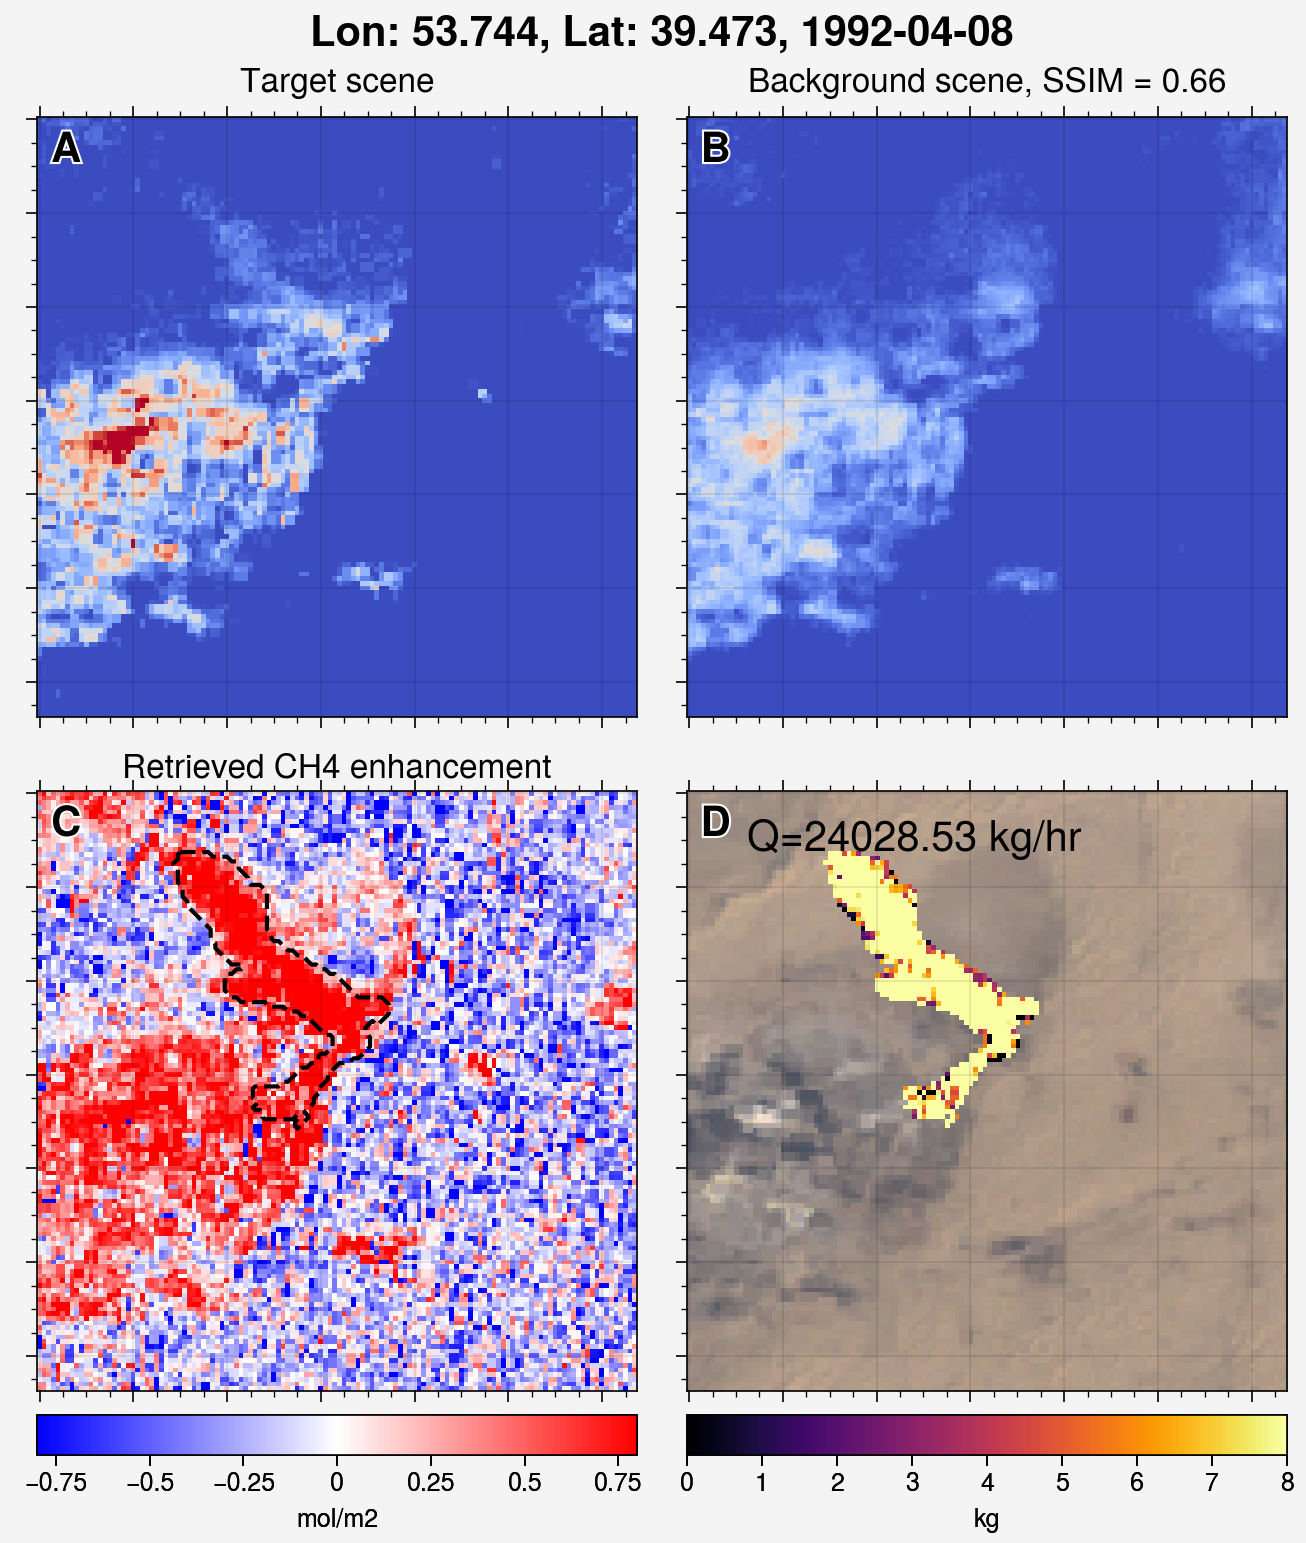

In [19]:
plot_plume( 53.744, 39.473, 1992, 4, 8)

1998-02-04 00:00:00
1997-08-08 06:37:03.037000 1998-08-03 06:37:03.037000
<class 'numpy.ndarray'>
1998-02-04 00:00:00 [datetime.datetime(1997, 8, 12, 0, 0) datetime.datetime(1997, 8, 28, 0, 0)
 datetime.datetime(1997, 9, 13, 0, 0) datetime.datetime(1997, 9, 29, 0, 0)
 datetime.datetime(1997, 10, 15, 0, 0)
 datetime.datetime(1997, 11, 16, 0, 0)
 datetime.datetime(1997, 12, 2, 0, 0)
 datetime.datetime(1997, 12, 18, 0, 0) datetime.datetime(1998, 1, 3, 0, 0)
 datetime.datetime(1998, 1, 19, 0, 0) datetime.datetime(1998, 2, 4, 0, 0)
 datetime.datetime(1998, 2, 20, 0, 0) datetime.datetime(1998, 3, 8, 0, 0)
 datetime.datetime(1998, 3, 24, 0, 0) datetime.datetime(1998, 4, 9, 0, 0)
 datetime.datetime(1998, 4, 25, 0, 0) datetime.datetime(1998, 5, 11, 0, 0)
 datetime.datetime(1998, 6, 12, 0, 0) datetime.datetime(1998, 6, 28, 0, 0)
 datetime.datetime(1998, 7, 14, 0, 0) datetime.datetime(1997, 8, 19, 0, 0)
 datetime.datetime(1997, 9, 20, 0, 0) datetime.datetime(1997, 10, 6, 0, 0)
 datetime.datetime(

C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Creating the transmission spectrum...
--- 15.663628339767456 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.603981256484985 seconds --- to run radtran()
--- 93.07186794281006 seconds --- to optimize
Creating the transmission spectrum...
--- 15.31517481803894 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.533175706863403 seconds --- to run radtran()
--- 17.955360651016235 seconds --- to optimize


C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bo

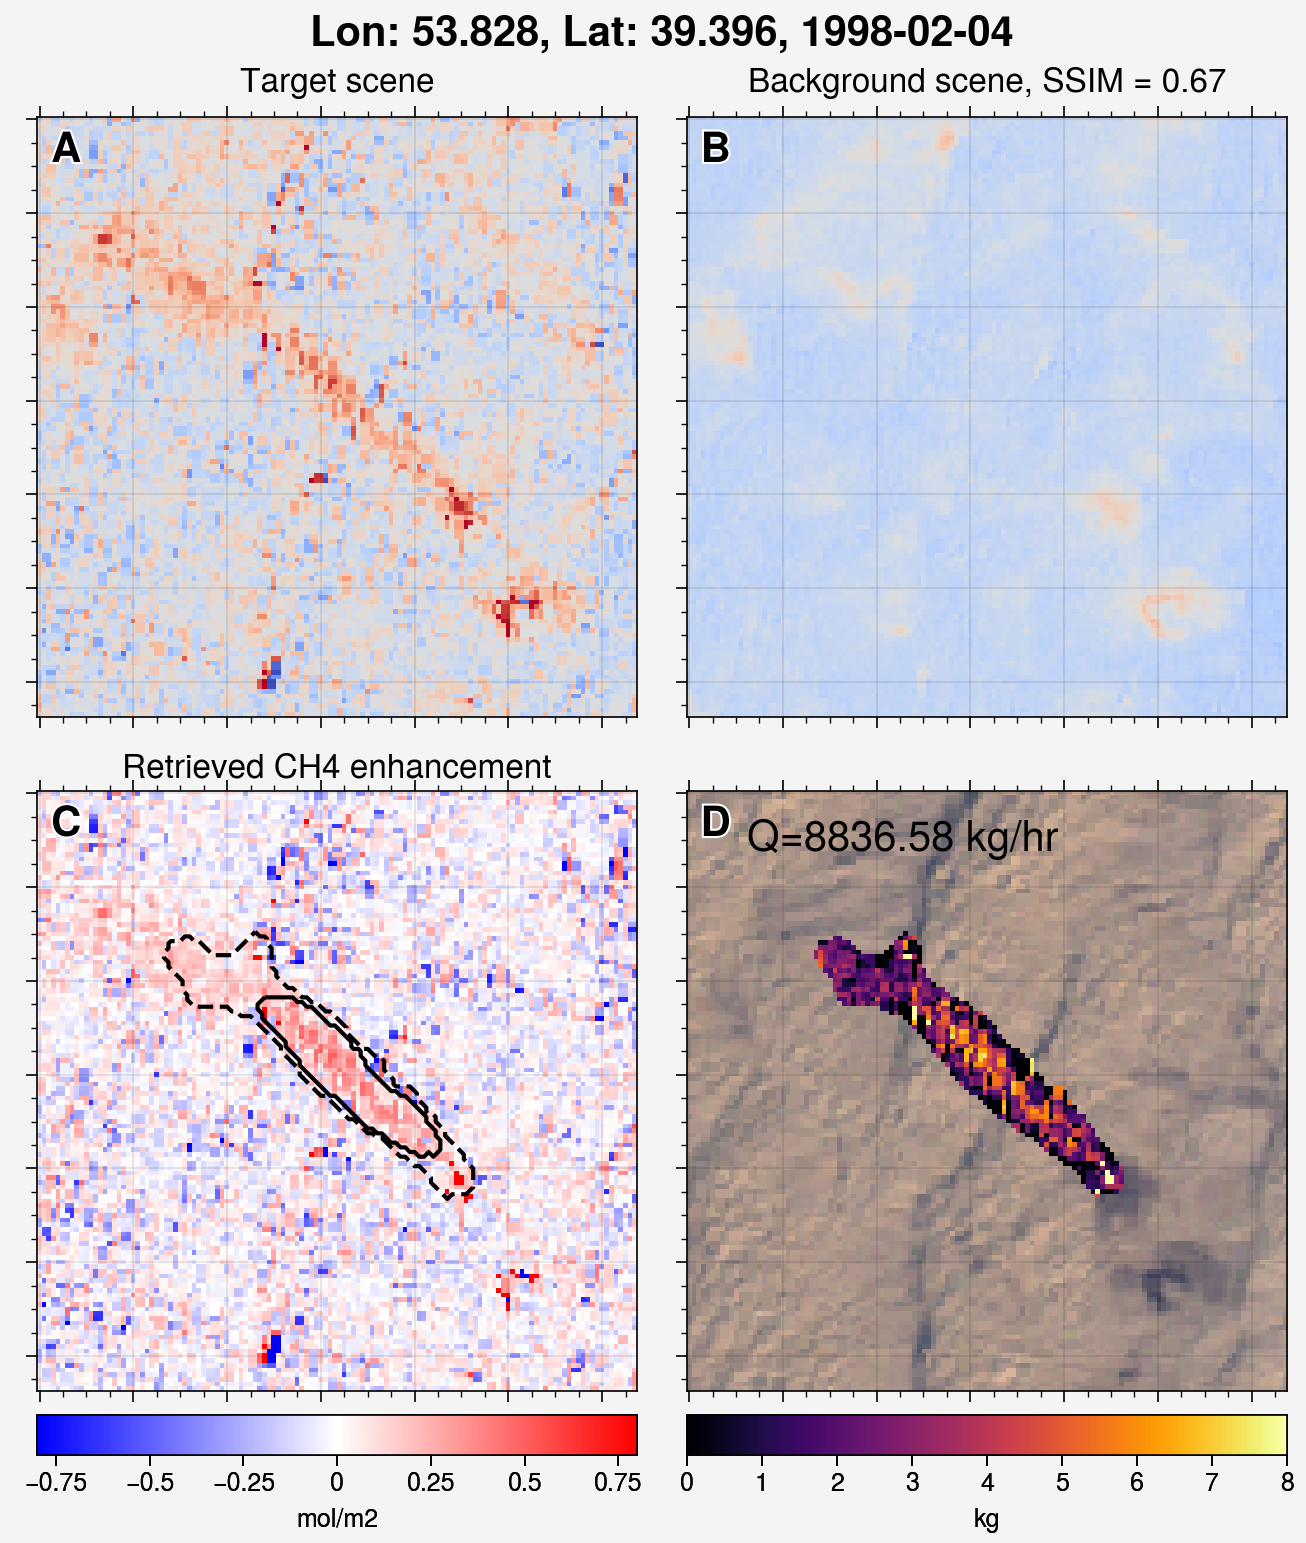

In [13]:
plot_plume( 53.828, 39.396, 1998, 2, 4)

1998-02-20 00:00:00
1997-08-24 06:37:21.771000 1998-08-19 06:37:21.771000
<class 'numpy.ndarray'>
1998-02-20 00:00:00 [datetime.datetime(1997, 8, 28, 0, 0) datetime.datetime(1997, 9, 13, 0, 0)
 datetime.datetime(1997, 9, 29, 0, 0)
 datetime.datetime(1997, 10, 15, 0, 0)
 datetime.datetime(1997, 11, 16, 0, 0)
 datetime.datetime(1997, 12, 2, 0, 0)
 datetime.datetime(1997, 12, 18, 0, 0) datetime.datetime(1998, 1, 3, 0, 0)
 datetime.datetime(1998, 1, 19, 0, 0) datetime.datetime(1998, 2, 4, 0, 0)
 datetime.datetime(1998, 2, 20, 0, 0) datetime.datetime(1998, 3, 8, 0, 0)
 datetime.datetime(1998, 3, 24, 0, 0) datetime.datetime(1998, 4, 9, 0, 0)
 datetime.datetime(1998, 4, 25, 0, 0) datetime.datetime(1998, 5, 11, 0, 0)
 datetime.datetime(1998, 6, 12, 0, 0) datetime.datetime(1998, 6, 28, 0, 0)
 datetime.datetime(1998, 7, 14, 0, 0) datetime.datetime(1998, 8, 15, 0, 0)
 datetime.datetime(1997, 9, 20, 0, 0) datetime.datetime(1997, 10, 6, 0, 0)
 datetime.datetime(1997, 10, 22, 0, 0)
 datetime.datetim

C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Creating the transmission spectrum...
--- 15.566231727600098 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.44637894630432 seconds --- to run radtran()
--- 26.73362708091736 seconds --- to optimize
Creating the transmission spectrum...
--- 15.323789358139038 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.245240211486816 seconds --- to run radtran()
--- 16.719165325164795 seconds --- to optimize


C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bo

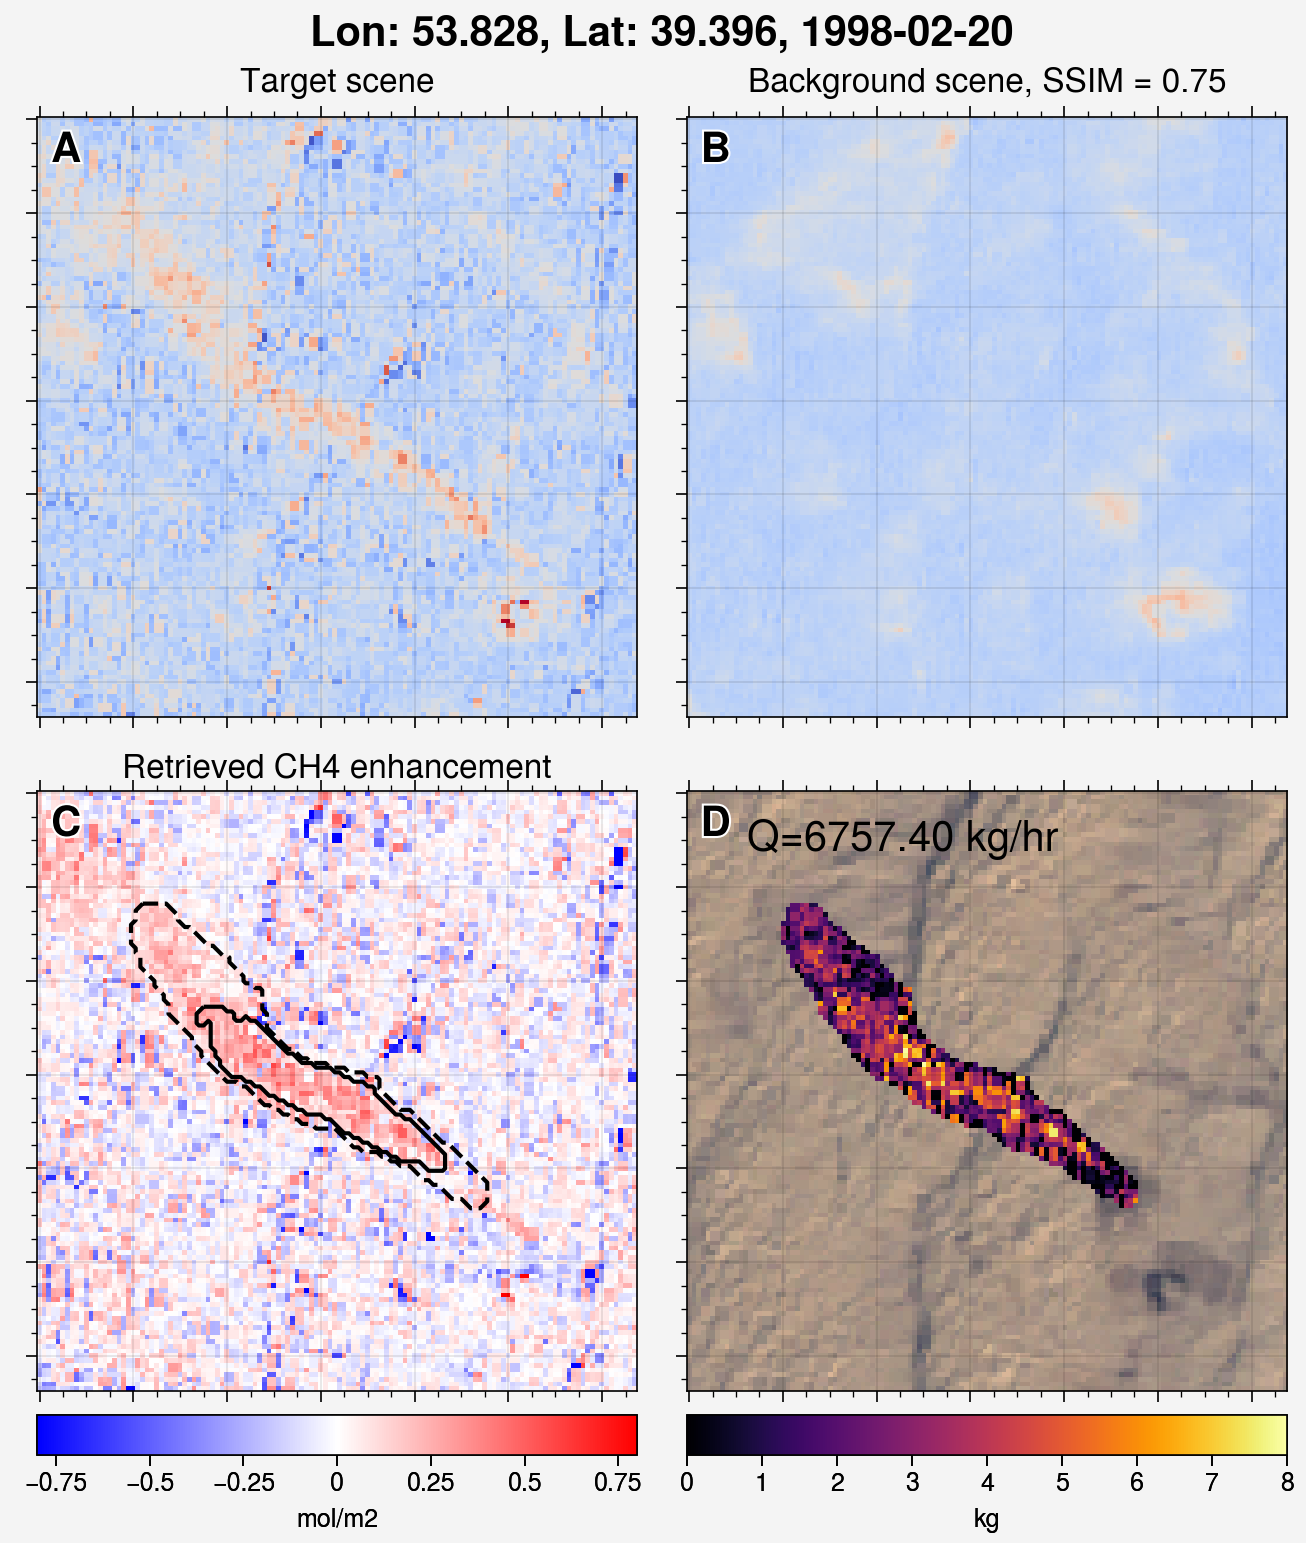

In [14]:
plot_plume( 53.828, 39.396, 1998, 2, 20)

1994-03-29 00:00:00
1993-09-30 06:21:32.007000 1994-09-25 06:21:32.007000
<class 'numpy.ndarray'>
1994-03-29 00:00:00 [datetime.datetime(1993, 10, 4, 0, 0)
 datetime.datetime(1993, 10, 20, 0, 0)
 datetime.datetime(1993, 11, 5, 0, 0)
 datetime.datetime(1993, 11, 21, 0, 0)
 datetime.datetime(1993, 12, 7, 0, 0)
 datetime.datetime(1993, 12, 23, 0, 0) datetime.datetime(1994, 1, 8, 0, 0)
 datetime.datetime(1994, 1, 24, 0, 0) datetime.datetime(1994, 2, 25, 0, 0)
 datetime.datetime(1994, 3, 29, 0, 0) datetime.datetime(1994, 4, 14, 0, 0)
 datetime.datetime(1994, 4, 30, 0, 0) datetime.datetime(1994, 5, 16, 0, 0)
 datetime.datetime(1994, 6, 1, 0, 0) datetime.datetime(1994, 6, 17, 0, 0)
 datetime.datetime(1994, 7, 3, 0, 0) datetime.datetime(1994, 8, 4, 0, 0)
 datetime.datetime(1994, 8, 20, 0, 0) datetime.datetime(1994, 9, 5, 0, 0)
 datetime.datetime(1994, 9, 21, 0, 0)
 datetime.datetime(1993, 10, 11, 0, 0)
 datetime.datetime(1993, 10, 27, 0, 0)
 datetime.datetime(1993, 12, 14, 0, 0)
 datetime.date

C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Creating the transmission spectrum...
--- 15.572497367858887 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.46118998527527 seconds --- to run radtran()
--- 26.32494592666626 seconds --- to optimize
Creating the transmission spectrum...
--- 15.313680648803711 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.20937728881836 seconds --- to run radtran()
--- 22.625916481018066 seconds --- to optimize


C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bo

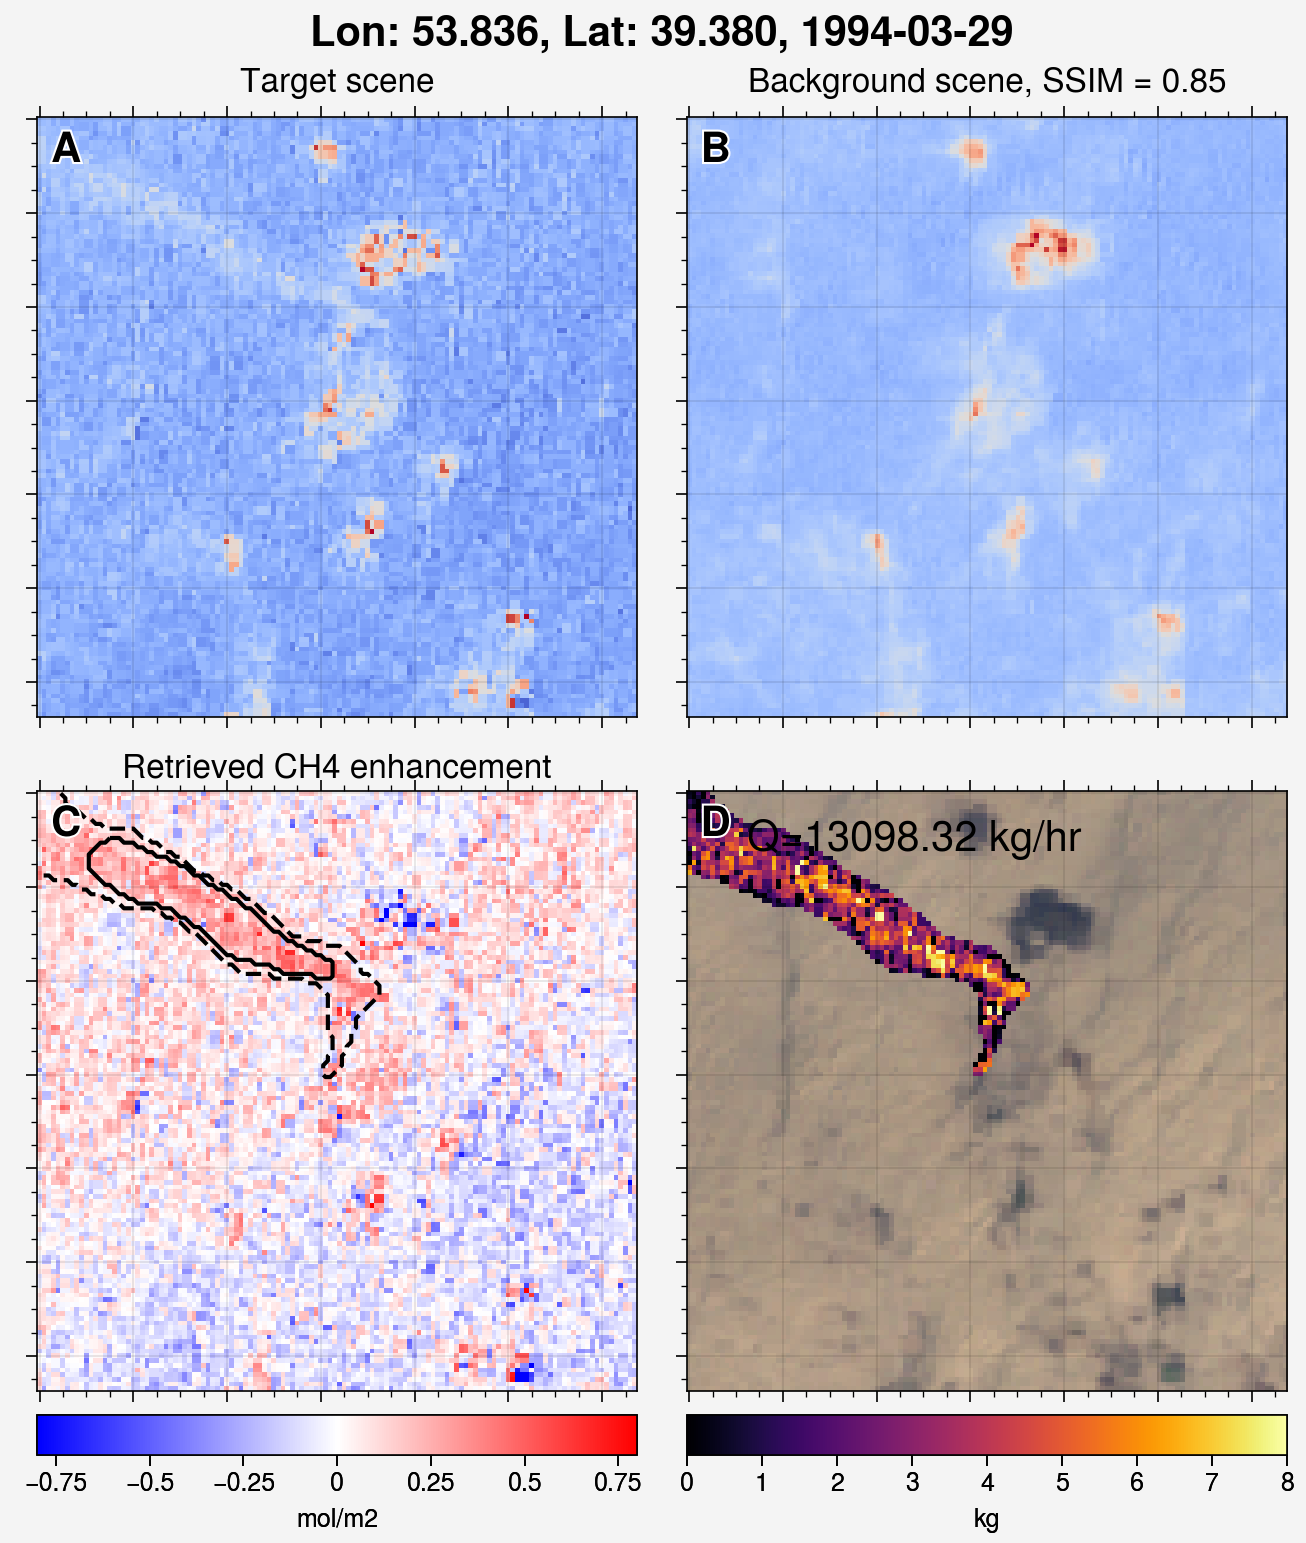

In [15]:
plot_plume( 53.836, 39.380, 1994, 3, 29)

1996-12-21 00:00:00
1996-06-24 05:46:32.374000 1997-06-19 05:46:32.374000
<class 'numpy.ndarray'>
1996-12-21 00:00:00 [datetime.datetime(1996, 6, 28, 0, 0) datetime.datetime(1996, 7, 14, 0, 0)
 datetime.datetime(1996, 7, 30, 0, 0) datetime.datetime(1996, 8, 15, 0, 0)
 datetime.datetime(1996, 8, 31, 0, 0) datetime.datetime(1996, 9, 16, 0, 0)
 datetime.datetime(1996, 10, 2, 0, 0)
 datetime.datetime(1996, 10, 18, 0, 0)
 datetime.datetime(1996, 11, 3, 0, 0)
 datetime.datetime(1996, 11, 19, 0, 0)
 datetime.datetime(1996, 12, 5, 0, 0)
 datetime.datetime(1996, 12, 21, 0, 0) datetime.datetime(1997, 1, 6, 0, 0)
 datetime.datetime(1997, 1, 22, 0, 0) datetime.datetime(1997, 2, 7, 0, 0)
 datetime.datetime(1997, 3, 11, 0, 0) datetime.datetime(1997, 4, 12, 0, 0)
 datetime.datetime(1997, 4, 28, 0, 0) datetime.datetime(1997, 5, 14, 0, 0)
 datetime.datetime(1997, 6, 15, 0, 0) datetime.datetime(1996, 7, 5, 0, 0)
 datetime.datetime(1996, 7, 21, 0, 0) datetime.datetime(1996, 8, 6, 0, 0)
 datetime.datetime

C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Creating the transmission spectrum...
--- 15.481348514556885 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.51982045173645 seconds --- to run radtran()
--- 640.6071846485138 seconds --- to optimize
Creating the transmission spectrum...
--- 15.454068660736084 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.364819049835205 seconds --- to run radtran()
--- 1795.2053966522217 seconds --- to optimize


C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bo

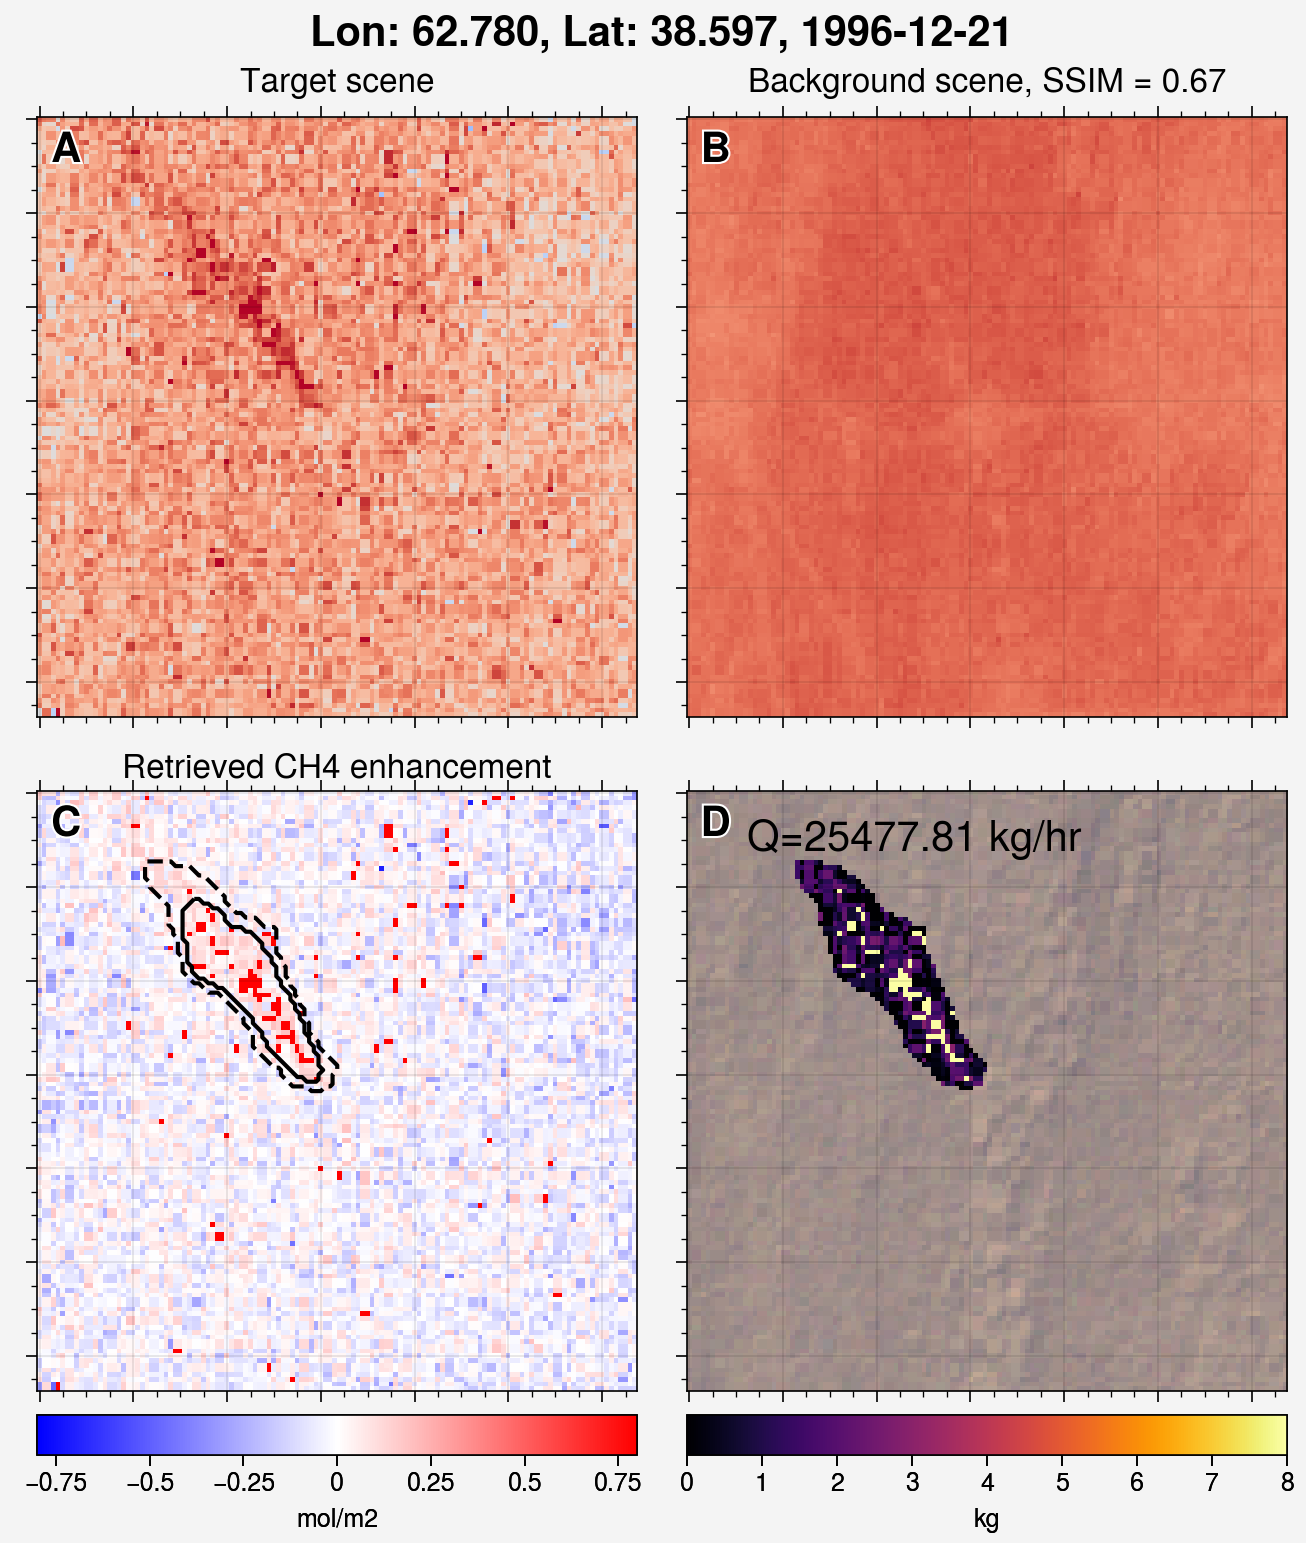

In [16]:
plot_plume( 62.78, 38.597, 1996, 12, 21)

1989-02-08 00:00:00
1988-08-12 06:01:01.709000 1989-08-07 06:01:01.709000
<class 'numpy.ndarray'>
1989-02-08 00:00:00 [datetime.datetime(1988, 8, 16, 0, 0) datetime.datetime(1988, 9, 1, 0, 0)
 datetime.datetime(1988, 9, 17, 0, 0) datetime.datetime(1988, 10, 3, 0, 0)
 datetime.datetime(1988, 10, 19, 0, 0)
 datetime.datetime(1988, 11, 20, 0, 0)
 datetime.datetime(1988, 12, 6, 0, 0)
 datetime.datetime(1988, 12, 22, 0, 0)
 datetime.datetime(1989, 1, 23, 0, 0) datetime.datetime(1989, 2, 8, 0, 0)
 datetime.datetime(1989, 4, 13, 0, 0) datetime.datetime(1989, 5, 15, 0, 0)
 datetime.datetime(1989, 5, 31, 0, 0) datetime.datetime(1989, 6, 16, 0, 0)
 datetime.datetime(1989, 7, 2, 0, 0) datetime.datetime(1989, 7, 18, 0, 0)] [ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True]
[ 0.76343581  0.70275975  0.51297829 -0.13610958  0.41947352  0.32535756
  0.72610915  0.24097939  0.67517867  0.71400488  0.36423764  0.75862319
  0.41179533  0.71916515  0.761966

C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(128, 128) (128, 128) (128, 128) (128, 128) (128, 128)
(1, 6, 128, 128)
Creating the transmission spectrum...
--- 15.333645582199097 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.355597496032715 seconds --- to run radtran()
--- 15.275714874267578 seconds --- to optimize
Creating the transmission spectrum...
--- 15.341056108474731 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.250945806503296 seconds --- to run radtran()
--- 13.562057256698608 seconds --- to optimize


C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', 

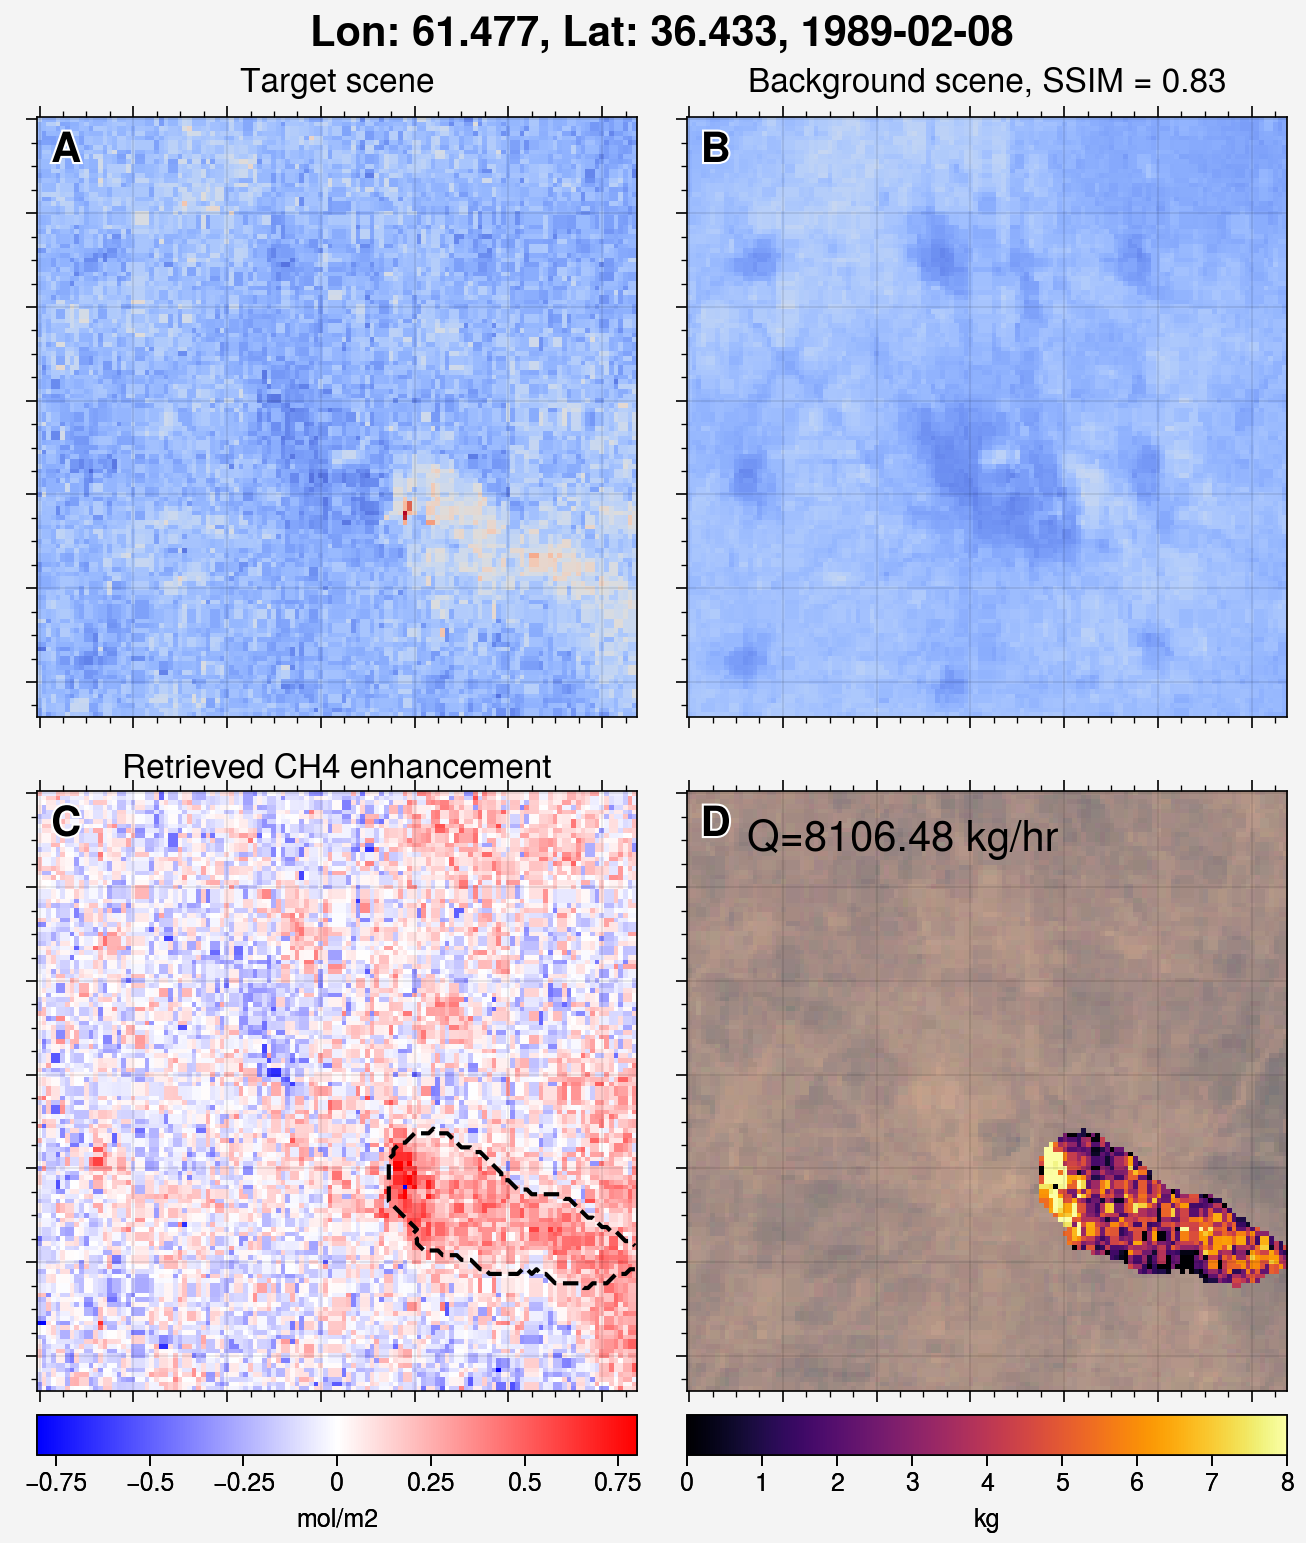

In [17]:
plot_plume(61.477, 36.433, 1989, 2, 8)

1989-07-02 00:00:00
1989-01-03 05:58:41.098000 1989-12-29 05:58:41.098000
<class 'numpy.ndarray'>
1989-07-02 00:00:00 [datetime.datetime(1989, 1, 23, 0, 0) datetime.datetime(1989, 2, 8, 0, 0)
 datetime.datetime(1989, 4, 13, 0, 0) datetime.datetime(1989, 5, 15, 0, 0)
 datetime.datetime(1989, 5, 31, 0, 0) datetime.datetime(1989, 6, 16, 0, 0)
 datetime.datetime(1989, 7, 2, 0, 0) datetime.datetime(1989, 7, 18, 0, 0)
 datetime.datetime(1989, 9, 4, 0, 0) datetime.datetime(1989, 10, 22, 0, 0)
 datetime.datetime(1989, 12, 25, 0, 0)] [ True  True  True  True  True  True False  True  True  True  True]
[0.58552177 0.71916515 0.73483308 0.29131208 0.8981948  0.62926123
 0.7434191  0.74096484 0.63068272 0.47744449]


C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(128, 128) (128, 128) (128, 128) (128, 128) (128, 128)
(1, 6, 128, 128)
Creating the transmission spectrum...
--- 15.537418365478516 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.27303910255432 seconds --- to run radtran()
--- 11.620342254638672 seconds --- to optimize
Creating the transmission spectrum...
--- 15.457690477371216 seconds --- to run radtran()
Creating the transmission spectrum...
--- 19.2779541015625 seconds --- to run radtran()
--- 13.935231447219849 seconds --- to optimize


C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_35308\894962189.py:107: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bo

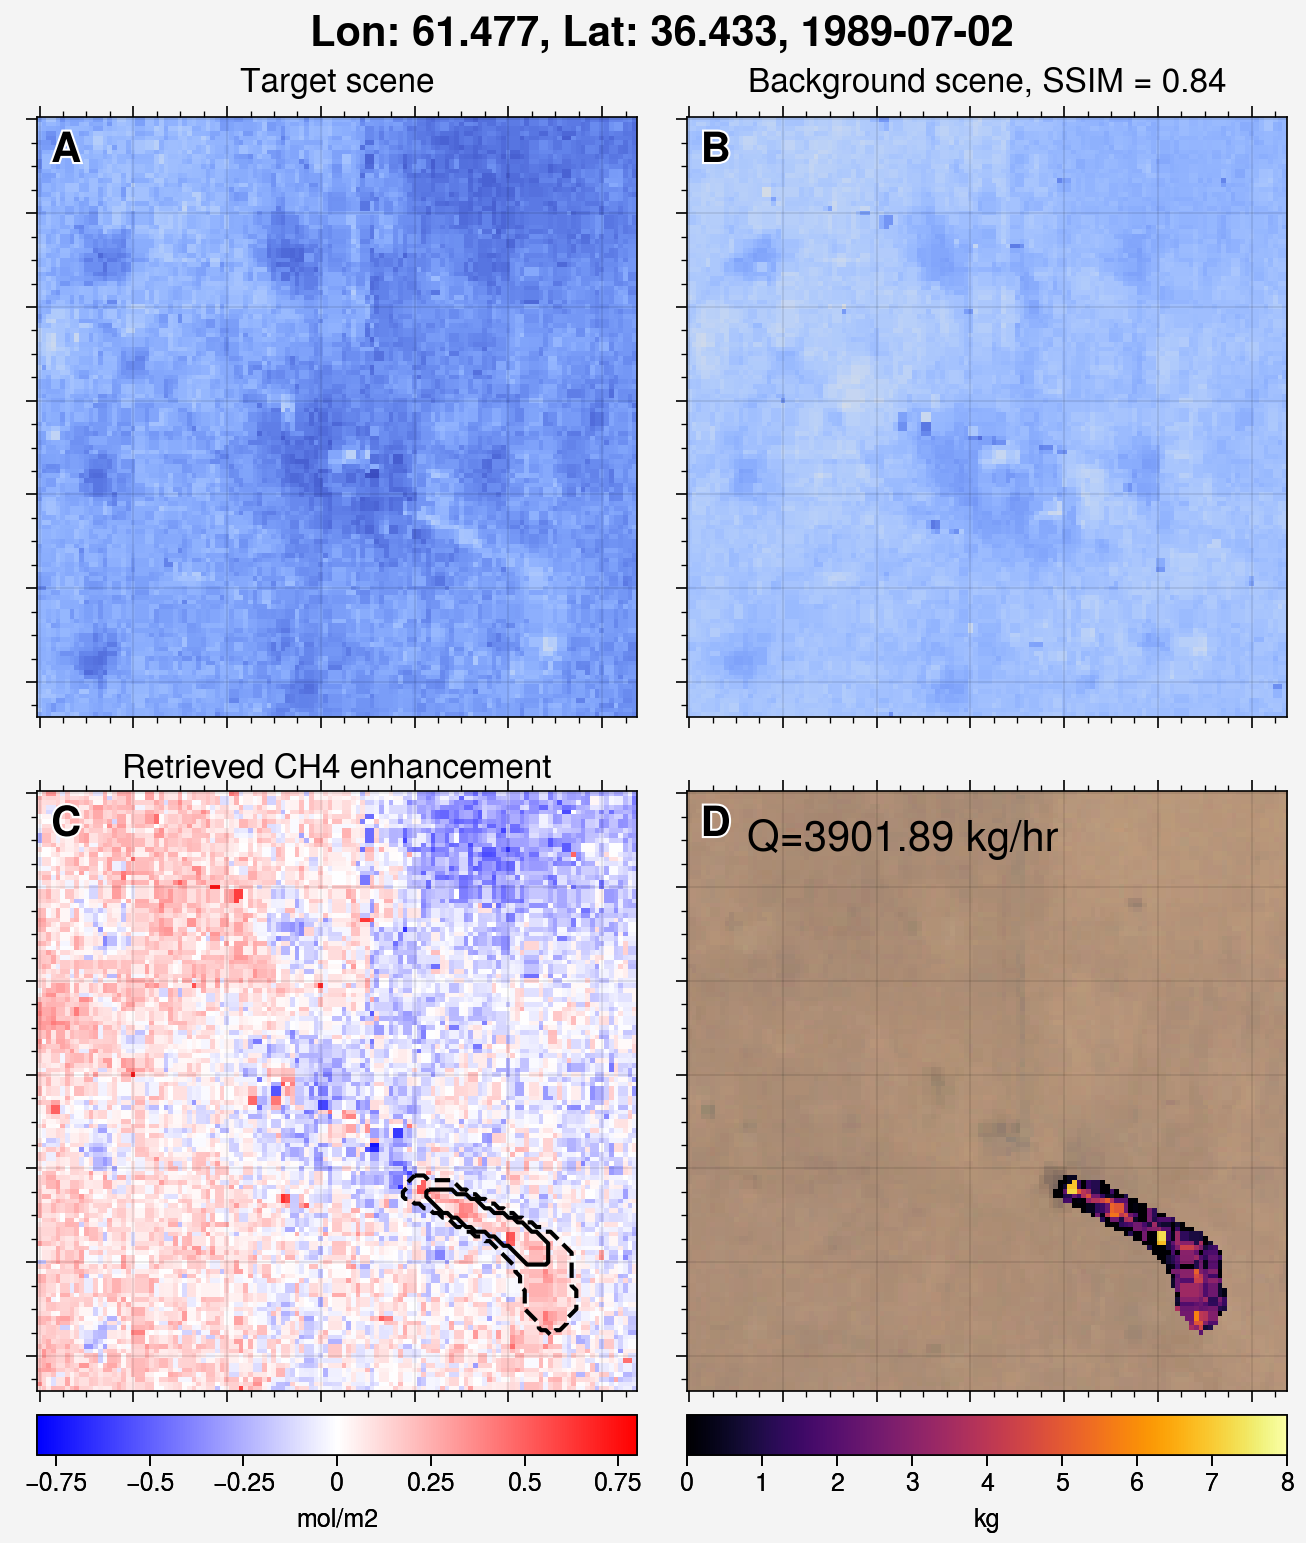

In [18]:
plot_plume(61.477, 36.433, 1989, 7, 2)

In [10]:
start_time = datetime(1990, 10, 1, 0, 0)
end_time = datetime(1990, 11, 1, 0, 0)
lonnow = 61.673
latnow = 36.512
img_id_list, date_list, img_date_list, imgchannels, imgxch4, imglons, imglats, u10m, v10m = get_plume(lonnow, 
                                                                                                      latnow, 
                                                                                                      start_time.strftime('%Y-%m-%d'), 
                                                                                                      end_time.strftime('%Y-%m-%d'), 
                                                                                                      1.5, 1.5, 
                                                                                                      do_retrieval=False, 
                                                                                                      satellite='Landsat 5')
bg, drmbg, dr = find_bg(lonnow, latnow, img_date_list[0], imgchannels[0, :, :, 0])

num_layers = 100
targheight = 0
obsheight  = 100
solarangle = 40
obsangle   = 0
instrument = 'L4'
method     = 'MBSP'
ch4 = -rt.retrieve(dr, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)
ch4bg = -rt.retrieve(bg, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)

KeyboardInterrupt: 

In [117]:
pnet_models_weights = glob.glob('model_weights/*.h5')
meanmask = pred_plume_mask(imgchannels, bg, pnet_models_weights)

_0p1lvl= meanmask.copy()
_0p1lvl[_0p1lvl >= 0.1] = 1
_0p1lvl[_0p1lvl < 0.1] = 0

_0p5lvl = meanmask.copy()
_0p5lvl[_0p5lvl >= 0.75] = 1
_0p5lvl[_0p5lvl < 0.75] = 0

(128, 128) (128, 128) (128, 128) (128, 128) (128, 128)
(1, 6, 128, 128)


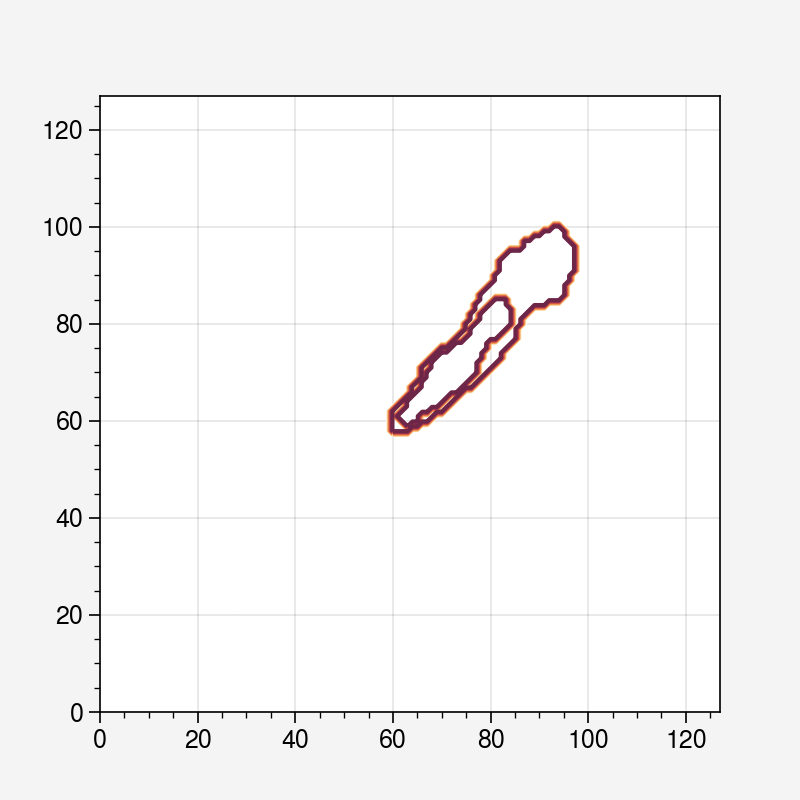

In [123]:
plt.contour(_0p5lvl, level=[0.5])
plt.contour(_0p1lvl, level=[0.5])

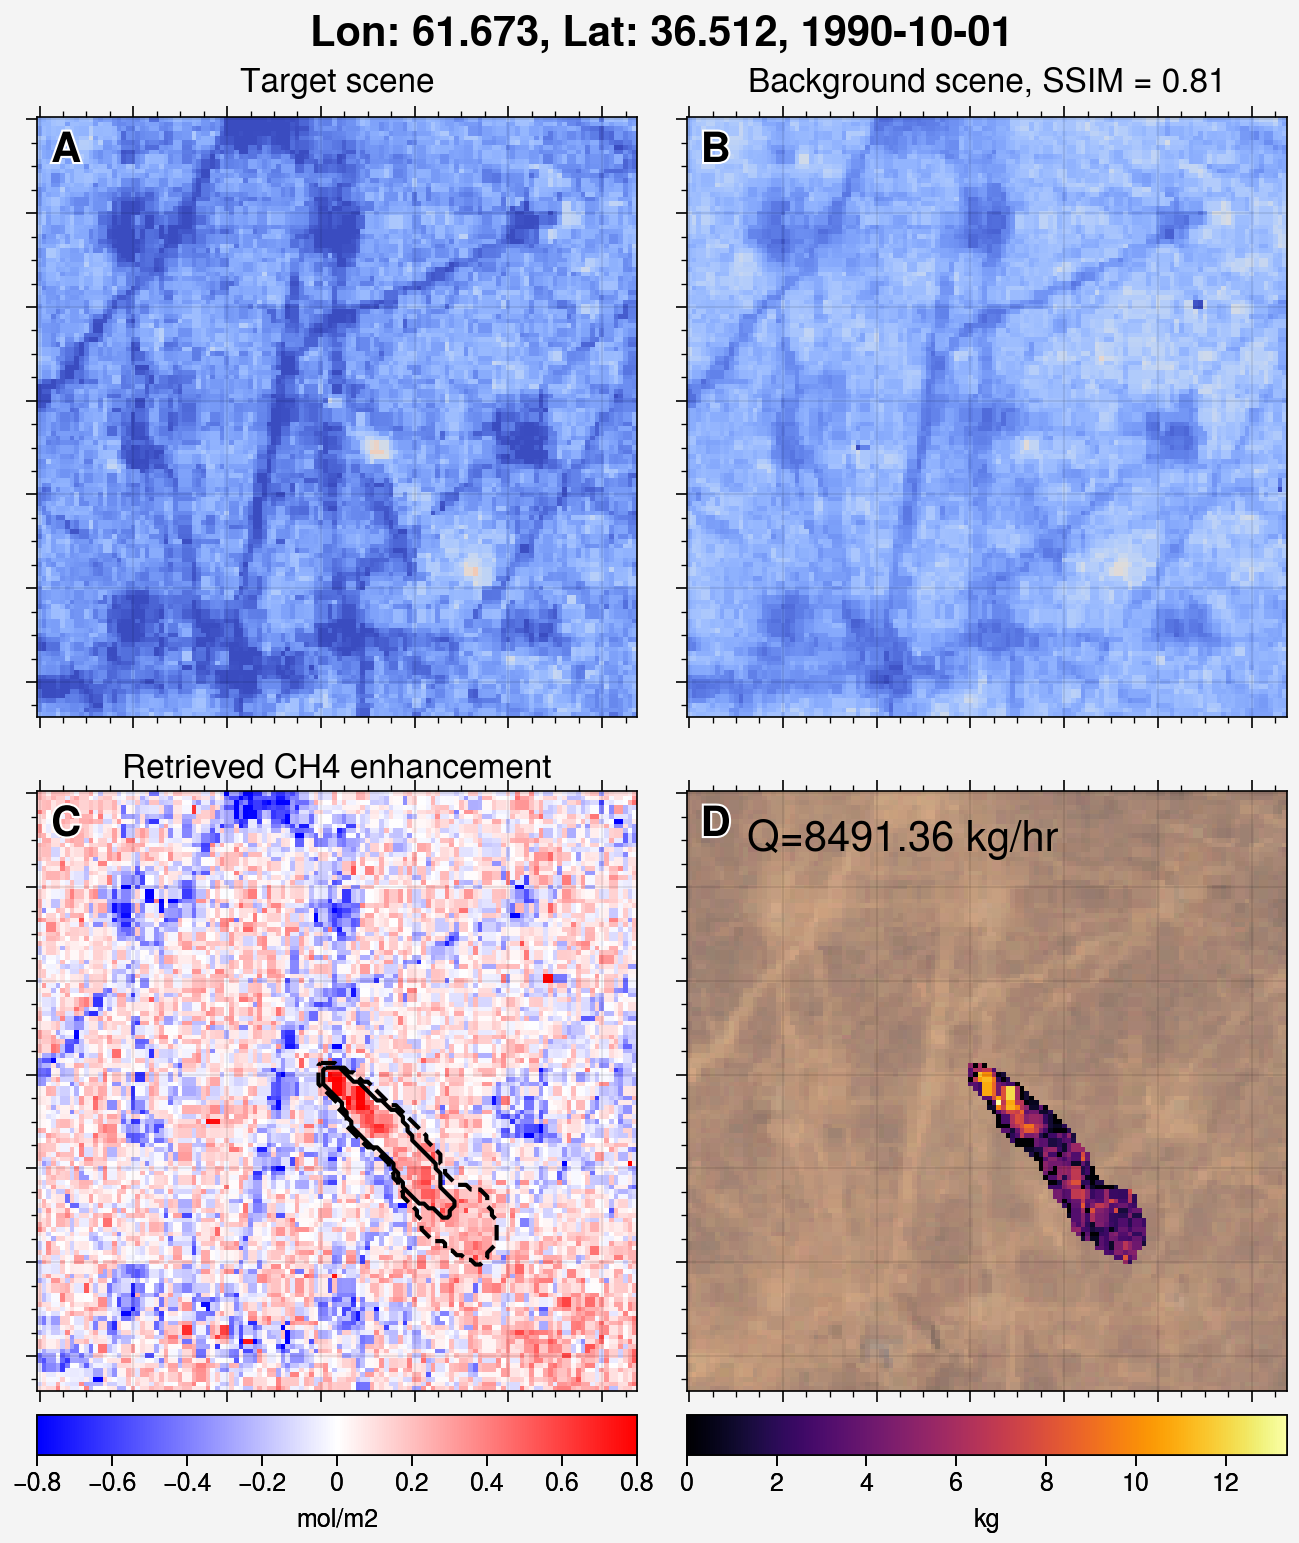

In [115]:
#### prepare figure
fig, axs = pplt.subplots(ncols=2, nrows=2, refwidth=3)
axs[0, 0].matshow(dr, cmap='coolwarm', vmin=0, vmax=0.5)
axs[0, 0].set_title('Target scene')
axs[0, 1].matshow(bg, cmap='coolwarm', vmin=0, vmax=0.5)
axs[0, 1].set_title('Background scene, SSIM = %.2f'%ssim(bg, dr))


# get rgb image
rgb = img_128[:, :, 1:4]
brightness = np.nanmean(np.sqrt(rgb[:,:,0]**2 + rgb[:,:,1]**2 + rgb[:,:,2]**2))
rgb = rgb/brightness


enhance = ch4-ch4bg
_maskout = _0p1lvl.copy()
_maskout[_0p1lvl == 1] = np.nan
_maskout[_0p1lvl == 0] = 1
bias = np.nanmean(enhance*_maskout)  # make sure mean enhancebend outside plume mask is zero
enhance = enhance - bias

im = axs[1, 0].matshow(enhance, cmap='bwr', vmin=-0.8, vmax=0.8)
_maskin = _0p1lvl.copy()
axs[1, 0].contour(_maskin, levels=[0.5], colors='black', linestyles='dashed')
_maskin[_maskin <= 0.1] = np.nan
axs[1, 0].contour(_0p5lvl, levels=[0.5], colors='black', linestyles='solid')
axs[1, 0].set_title('Retrieved CH4 enhancement')
axs[1, 0].colorbar(im, loc='b', label='mol/m2')

ratio = imgchannels[0, :, :, 0].shape[0]/128
pixelsize = (30*ratio)**2 # m^2
ch4kg = enhance*pixelsize*16.04/1000
windspeed = np.sqrt(u10m[0]**2 + v10m[0]**2)
ueffect = 0.33*windspeed+0.45
ime = ch4kg*_maskin
imesum = np.nansum(ime)
LLL = np.sqrt(np.nansum(_maskin)*pixelsize)
QQQ = imesum*ueffect/LLL*3600.
axs[1, 1].text(0.1, 0.9, 'Q=%.2f kg/hr'%QQQ, transform=axs[1, 1].transAxes, fontsize=15)

im_temp = axs[1, 1].matshow(ime, cmap='inferno', vmin=0)
rgb[np.where(~np.isnan(ime))] = im_temp.cmap(im_temp.norm(ime[np.where(~np.isnan(_maskin))]))[:, :3] # [255, 0, 0]
im = axs[1, 1].imshow(rgb)
axs[1, 1].colorbar(im_temp, loc='b', label='kg')

fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
          suptitle='Lon: %.3f, Lat: %.3f, %s'%(lonnow, latnow, start_time.strftime('%Y-%m-%d')), suptitlesize=15)


In [29]:
img_128 = np.zeros((128, 128, 9))
for i in range(8):
    img_128[:, :, i] = interp2d(imgchannels[0, :, :, i])
img_128[:, :, 8] = bg

_img128 = transform_raw_image(img_128)

plt.matshow(_img128[0, 3])


pred = torch.tensor(_img128.astype(np.float32))
pred = pnet_model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]
print(pred.shape)

plt.matshow(pred, cmap='binary')

NameError: name 'bg' is not defined

In [108]:
start_time = datetime(1990, 10, 1, 0, 0)
end_time = datetime(1990, 11, 1, 0, 0)
lonnow = 61.673
latnow = 36.512
img_id_list, date_list, img_date_list, imgchannels, imgxch4, imglons, imglats, u10m, v10m = get_plume(lonnow, 
                                                                                                      latnow, 
                                                                                                      start_time.strftime('%Y-%m-%d'), 
                                                                                                      end_time.strftime('%Y-%m-%d'), 
                                                                                                      1.5, 1.5, 
                                                                                                      do_retrieval=False, 
                                                                                                      satellite='Landsat 5')
bg, drmbg, dr = find_bg(lonnow, latnow, img_date_list[0], imgchannels[0, :, :, 0])

num_layers = 100
targheight = 0
obsheight  = 100
solarangle = 40
obsangle   = 0
instrument = 'L4'
method     = 'MBSP'
ch4 = -rt.retrieve(dr, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)
ch4bg = -rt.retrieve(bg, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)



[datetime.datetime(1990, 10, 9, 5, 50, 37, 244000),
 datetime.datetime(1990, 10, 25, 5, 50, 32, 980000)]

(128, 128) (128, 128) (128, 128) (128, 128) (128, 128)
(1, 6, 128, 128)


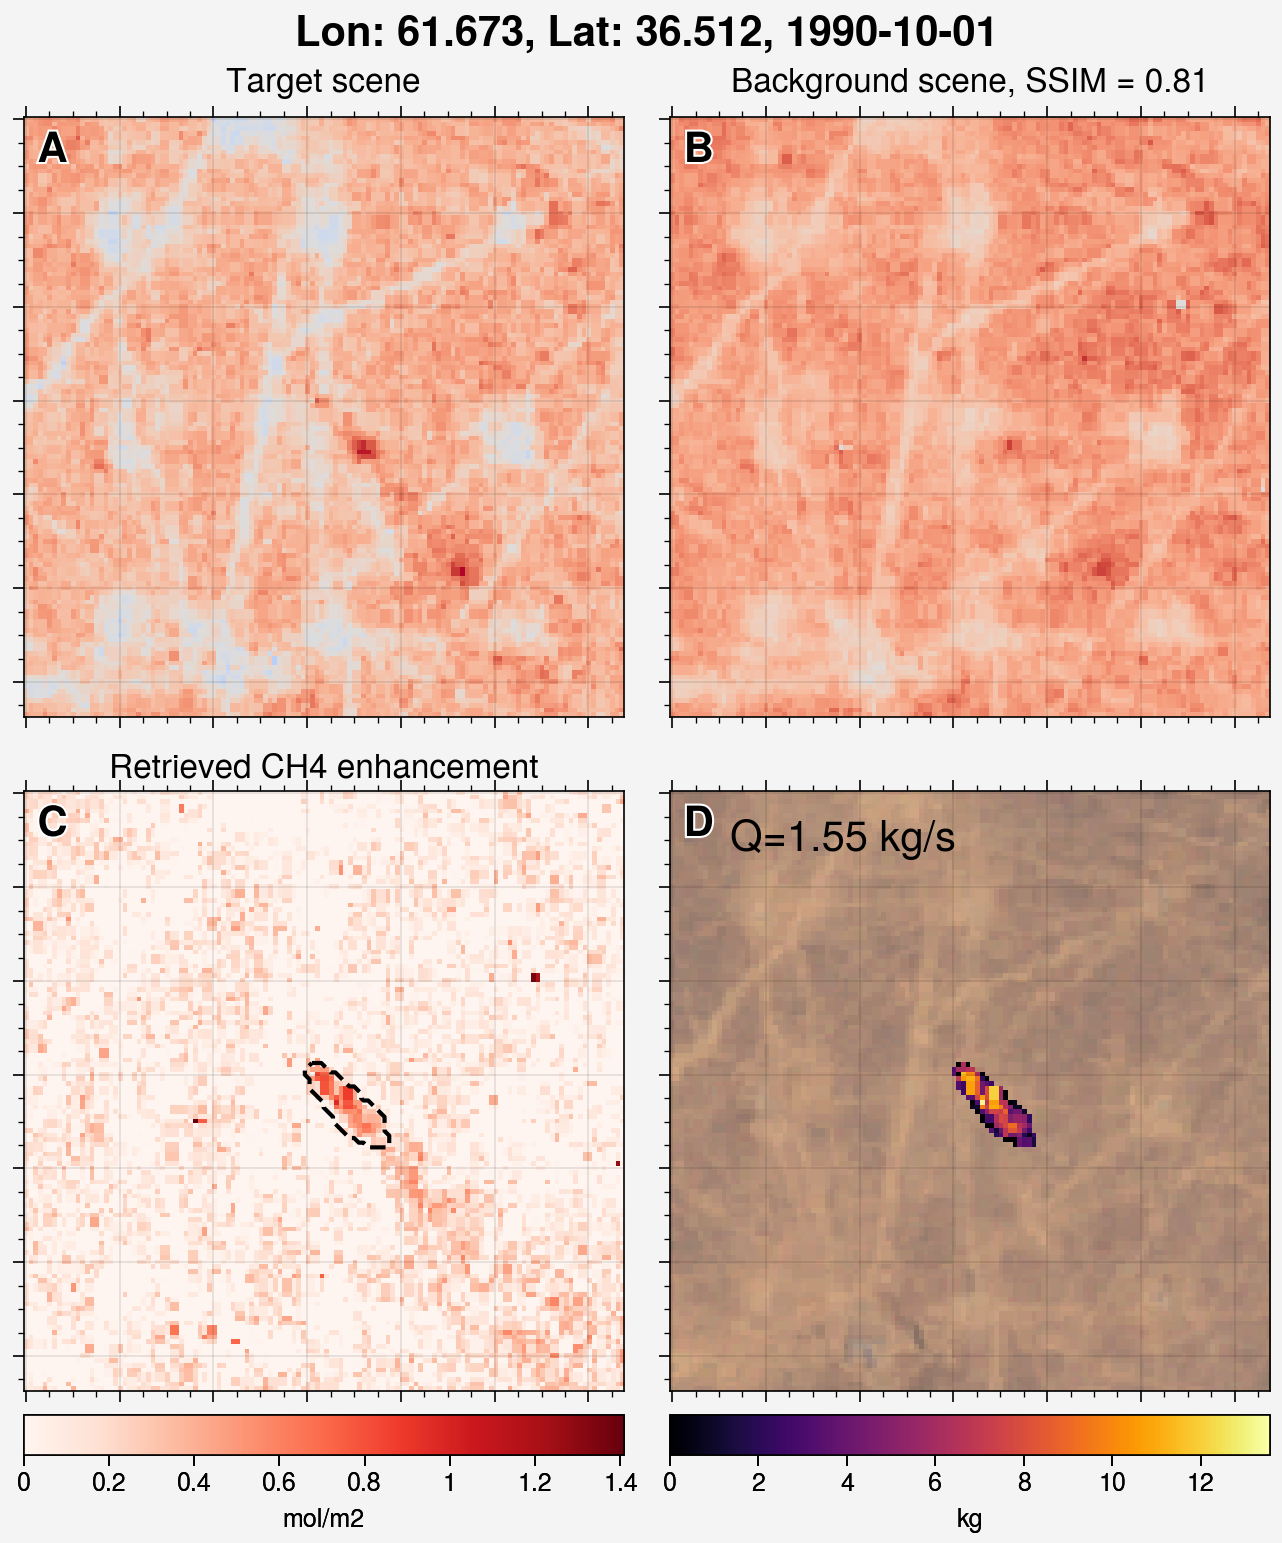

In [126]:
fig, axs = pplt.subplots(ncols=2, nrows=2, refwidth=3)

im = axs[0, 0].matshow(dr, cmap='coolwarm')
axs[0, 0].set_title('Target scene')
vmin, vmax = im.get_clim()

axs[0, 1].matshow(bg, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Background scene, SSIM = %.2f'%ssim(bg, dr))



img_128 = np.zeros((128, 128, 9))
ratio = imgchannels[0, :, :, 0].shape[0]/128
pixelsize = (30*ratio)**2 # m^2
for i in range(8):
    img_128[:, :, i] = interp2d(imgchannels[0, :, :, i])
img_128[:, :, 8] = bg
_img128 = transform_raw_image(img_128)
maskpred = torch.tensor(_img128.astype(np.float32))
maskpred = pnet_model(maskpred.to(device))
maskpred = maskpred.detach().cpu().numpy()[0,0,:,:]
maskpred[maskpred > 0.1] = 1
maskpred[maskpred <= 0.1] = 0

# get rgb image
rgb = img_128[:, :, 1:4]
brightness = np.nanmean(np.sqrt(rgb[:,:,0]**2 + rgb[:,:,1]**2 + rgb[:,:,2]**2))
rgb = rgb/brightness

enhance = ch4-ch4bg
_maskpred = maskpred.copy()
_maskpred[_maskpred == 1] = np.nan
_maskpred[_maskpred == 0] = 1
bias = np.nanmean(enhance*_maskpred)
enhance = enhance - bias

im = axs[1, 0].matshow(enhance, cmap='reds', vmin=0)
axs[1, 0].contour(maskpred, levels=[0.5], colors='black', linestyles='dashed')
maskpred[maskpred <= 0.1] = np.nan
axs[1, 0].set_title('Retrieved CH4 enhancement')
axs[1, 0].colorbar(im, loc='b', label='mol/m2')
vmin, vmax = im.get_clim()

ch4kg = enhance*pixelsize*16.04/1000.
windspeed = np.sqrt(u10m[0]**2 + v10m[0]**2)
ueffect = 0.9*np.log(windspeed) + 0.6
ime = ch4kg*maskpred
ime = np.nansum(ime)
LLL = np.sqrt(np.nansum(maskpred)*pixelsize)
QQQ = ime*ueffect/LLL
axs[1, 1].text(0.1, 0.9, 'Q=%.2f kg/s'%QQQ, transform=axs[1, 1].transAxes, fontsize=15)

im_temp = axs[1, 1].matshow(ch4kg, cmap='inferno', vmin=0, vmax=vmax*0.7*pixelsize*16.04/1000.)
rgb[np.where(~np.isnan(maskpred))] = im_temp.cmap(im_temp.norm(ch4kg[np.where(~np.isnan(maskpred))]))[:, :3] # [255, 0, 0]
im = axs[1, 1].imshow(rgb)
axs[1, 1].colorbar(im_temp, loc='b', label='kg')

fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
          suptitle='Lon: %.3f, Lat: %.3f, %s'%(lonnow, latnow, start_time.strftime('%Y-%m-%d')), suptitlesize=15)

# plt.savefig('landsat1.png', dpi=200)

In [96]:
start_time = datetime(1993, 5, 20, 0, 0)
end_time = datetime(1993, 5, 21, 0, 0)
lonnow = 53.744
latnow = 39.473
img_id_list, date_list, img_date_list, imgchannels, imgxch4, imglons, imglats, u10m, v10m = get_plume(lonnow, 
                                                                                                      latnow, 
                                                                                                      start_time.strftime('%Y-%m-%d'), 
                                                                                                      end_time.strftime('%Y-%m-%d'), 
                                                                                                      1.5, 1.5, 
                                                                                                      do_retrieval=False, 
                                                                                                      satellite='Landsat 5')
img_date_list

[datetime.datetime(1993, 5, 20, 6, 29, 23, 715000),
 datetime.datetime(1993, 5, 20, 6, 29, 47, 659000)]

In [97]:
bg, drmbg, dr = find_bg(lonnow, latnow, img_date_list[0], imgchannels[0, :, :, 0])

num_layers = 100
targheight = 0
obsheight  = 100
solarangle = 40
obsangle   = 0
instrument = 'L4'
method     = 'MBSP'
ch4 = -rt.retrieve(dr, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)
ch4bg = -rt.retrieve(bg, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)



1993-05-20 00:00:00
1992-11-21 06:29:23.715000 1993-11-16 06:29:23.715000
<class 'numpy.ndarray'>
1993-05-20 00:00:00 [datetime.datetime(1992, 12, 20, 0, 0) datetime.datetime(1993, 1, 5, 0, 0)
 datetime.datetime(1993, 1, 21, 0, 0) datetime.datetime(1993, 2, 6, 0, 0)
 datetime.datetime(1993, 2, 22, 0, 0) datetime.datetime(1993, 3, 26, 0, 0)
 datetime.datetime(1993, 4, 11, 0, 0) datetime.datetime(1993, 5, 13, 0, 0)
 datetime.datetime(1993, 5, 29, 0, 0) datetime.datetime(1993, 6, 14, 0, 0)
 datetime.datetime(1993, 6, 30, 0, 0) datetime.datetime(1993, 7, 16, 0, 0)
 datetime.datetime(1993, 8, 1, 0, 0) datetime.datetime(1993, 8, 17, 0, 0)
 datetime.datetime(1993, 10, 4, 0, 0)
 datetime.datetime(1993, 10, 20, 0, 0)
 datetime.datetime(1993, 11, 5, 0, 0)
 datetime.datetime(1992, 11, 25, 0, 0)
 datetime.datetime(1992, 12, 11, 0, 0)
 datetime.datetime(1993, 1, 12, 0, 0) datetime.datetime(1993, 1, 28, 0, 0)
 datetime.datetime(1993, 2, 13, 0, 0) datetime.datetime(1993, 3, 1, 0, 0)
 datetime.datetim

C:\Users\tailo\anaconda3\envs\ch4_labeller\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(128, 128) (128, 128) (128, 128) (128, 128) (128, 128)
(1, 6, 128, 128)
942.681884765625
0.0033160260123764676
0.020017634261139367


C:\Users\tailo\AppData\Local\Temp\ipykernel_42424\252889981.py:53: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_42424\252889981.py:53: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_42424\252889981.py:53: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
C:\Users\tailo\AppData\Local\Temp\ipykernel_42424\252889981.py:53: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  fig.format(suptitleweight='bold',

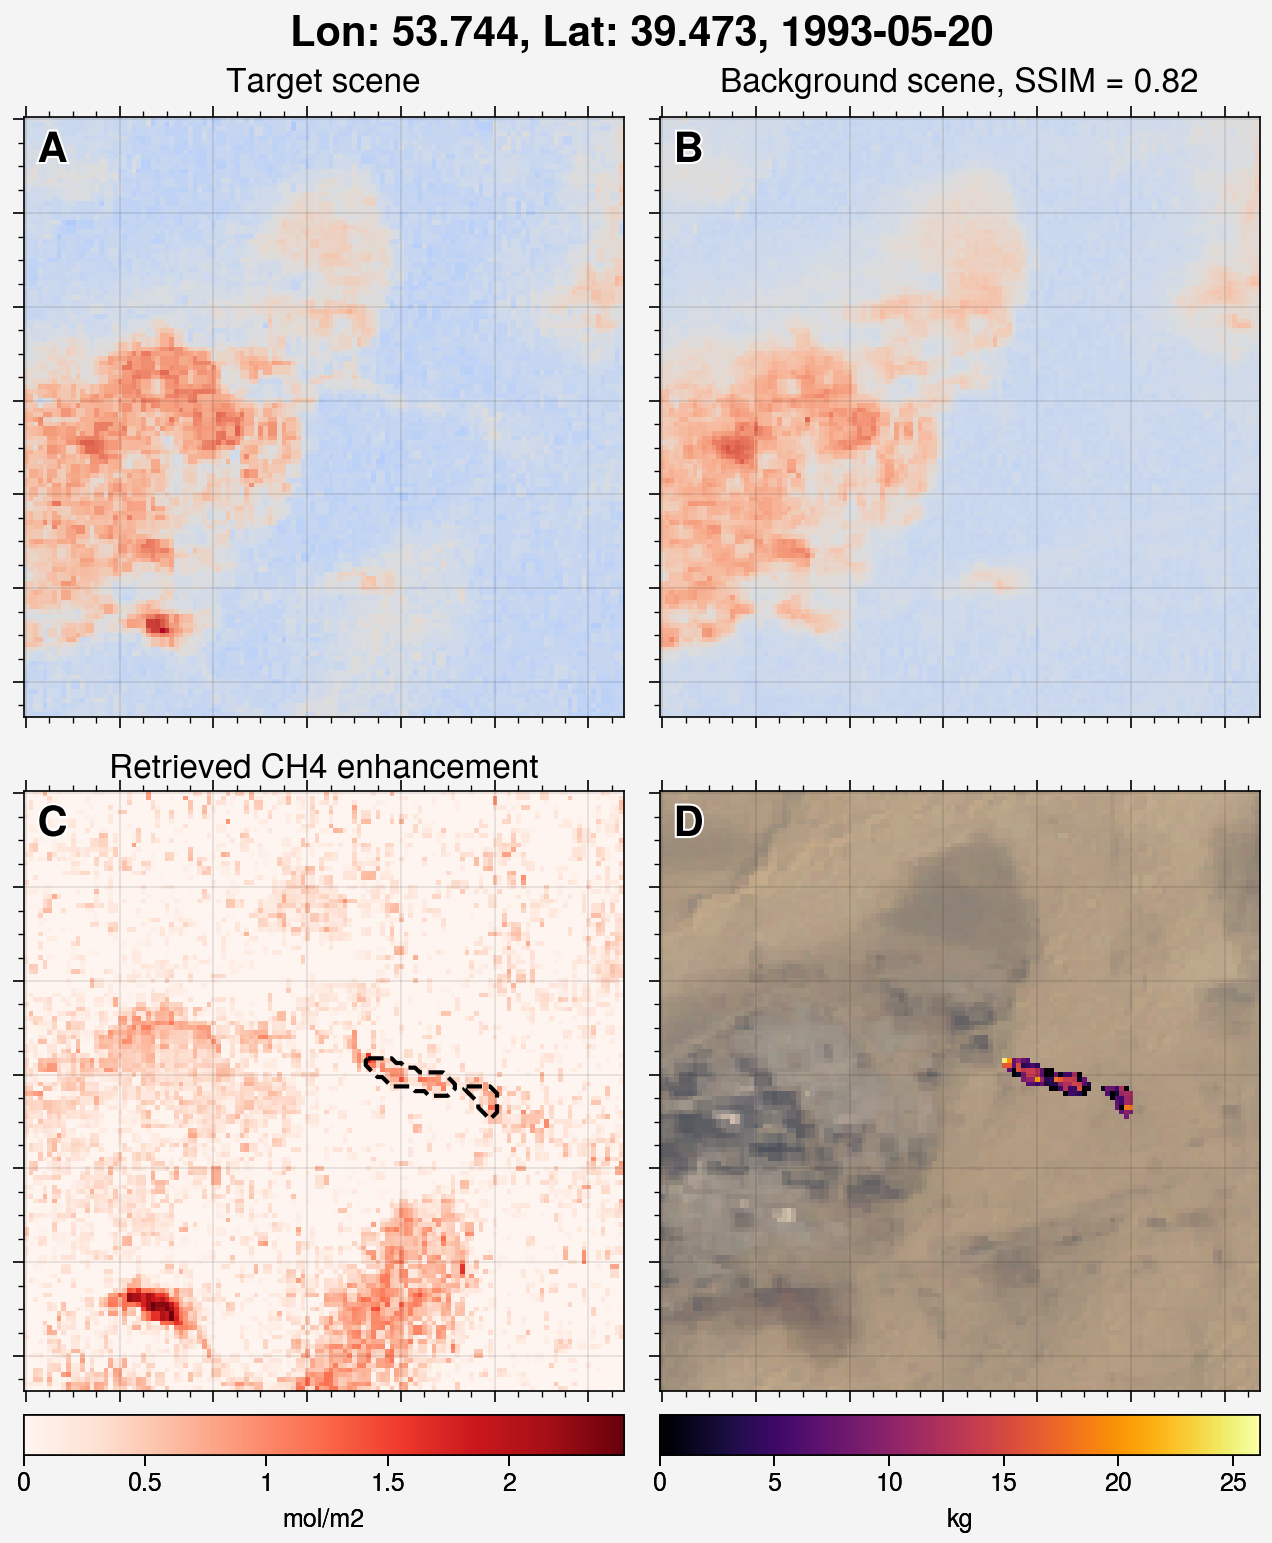

In [107]:
fig, axs = pplt.subplots(ncols=2, nrows=2, refwidth=3)

im = axs[0, 0].matshow(dr, cmap='coolwarm')
axs[0, 0].set_title('Target scene')
vmin, vmax = im.get_clim()

axs[0, 1].matshow(bg, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Background scene, SSIM = %.2f'%ssim(bg, dr))



img_128 = np.zeros((128, 128, 9))
ratio = imgchannels[0, :, :, 0].shape[0]/128
pixelsize = (30*ratio)**2 # m^2
for i in range(8):
    img_128[:, :, i] = interp2d(imgchannels[0, :, :, i])
img_128[:, :, 8] = bg
_img128 = transform(img_128)
maskpred = torch.tensor(_img128.astype(np.float32))
maskpred = pnet_model(maskpred.to(device))
maskpred = maskpred.detach().cpu().numpy()[0,0,:,:]
maskpred[maskpred > 0.1] = 1
maskpred[maskpred <= 0.1] = 0

# get rgb image
rgb = img_128[:, :, 1:4]
brightness = np.nanmean(np.sqrt(rgb[:,:,0]**2 + rgb[:,:,1]**2 + rgb[:,:,2]**2))
rgb = rgb/brightness

enhance = ch4-ch4bg
_maskpred = maskpred.copy()
_maskpred[_maskpred == 1] = np.nan
_maskpred[_maskpred == 0] = 1
bias = np.nanmean(enhance*_maskpred)
enhance = enhance - bias

im = axs[1, 0].matshow(enhance, cmap='reds', vmin=0)
axs[1, 0].contour(maskpred, levels=[0.5], colors='black', linestyles='dashed')
maskpred[maskpred <= 0.1] = np.nan
axs[1, 0].set_title('Retrieved CH4 enhancement')
axs[1, 0].colorbar(im, loc='b', label='mol/m2')
vmin, vmax = im.get_clim()

ch4kg = enhance*pixelsize*16.04/1000.
print(pixelsize)
print(np.mean(enhance))
print(np.median(ch4kg))
im_temp = axs[1, 1].matshow(ch4kg, cmap='inferno', vmin=0, vmax=vmax*0.7*pixelsize*16.04/1000.)
rgb[np.where(~np.isnan(maskpred))] = im_temp.cmap(im_temp.norm(ch4kg[np.where(~np.isnan(maskpred))]))[:, :3] # [255, 0, 0]
im = axs[1, 1].imshow(rgb)
axs[1, 1].colorbar(im_temp, loc='b', label='kg')

fig.format(suptitleweight='bold', titlesize=12, yticklabels=[], xticklabels=[], abc=True, abcloc='ul', abcstyle='A', abcsize=15,
          suptitle='Lon: %.3f, Lat: %.3f, %s'%(lonnow, latnow, start_time.strftime('%Y-%m-%d')), suptitlesize=15)

# plt.savefig('landsat1.png', dpi=200)

In [99]:
# plt.figure(figsize=(8, 8))
# ax = plt.subplot(221)
# ax.matshow(dr)
# ax.set_title('Target scene')

# ax = plt.subplot(222)
# ax.matshow(bg)
# ax.set_title('Bg, SSIM = %.2f'%ssim(zstandard(bg), zstandard(dr)))
# ax = plt.subplot(223)
# ax.matshow(dr - bg, cmap='coolwarm')

# num_layers = 100
# targheight = 0
# obsheight  = 100
# solarangle = 40
# obsangle   = 0
# instrument = 'L4'
# method     = 'MBSP'
# ch4 = -rt.retrieve(dr, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)
# ch4bg = -rt.retrieve(bg, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)

# ax = plt.subplot(224)
# im = ax.matshow(ch4-ch4bg, cmap='bwr', vmin=-1.5, vmax=1.5)
# # plt.colorbar(im, orientation='horizontal', label='mol/m2')
# ax.set_title('Retrieved CH4 enhancement')

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax, orientation='vertical', label='mol/m2')

# plt.subplots_adjust(hspace=0.25, wspace=0.25, top=0.95, bottom=0.05, right=0.95, left=0.05)

2008-09-27 00:00:00
2008-06-29 06:45:49.851000 2008-12-26 06:45:49.851000
<class 'numpy.ndarray'>
2008-09-27 00:00:00 [datetime.datetime(2008, 7, 9, 0, 0) datetime.datetime(2008, 7, 25, 0, 0)
 datetime.datetime(2008, 8, 10, 0, 0) datetime.datetime(2008, 9, 27, 0, 0)
 datetime.datetime(2008, 10, 13, 0, 0)
 datetime.datetime(2008, 10, 29, 0, 0)
 datetime.datetime(2008, 11, 14, 0, 0)] [ True  True  True False  True  True  True]
[0 1 2 4 5 6]
[0.04806544 0.248167   0.31664079 0.70358705 0.41955132 0.36074444]
Creating the transmission spectrum...
--- 16.026126861572266 seconds --- to run radtran()
Creating the transmission spectrum...
--- 20.182018995285034 seconds --- to run radtran()
--- 9.403454780578613 seconds --- to optimize
Creating the transmission spectrum...
--- 16.23125672340393 seconds --- to run radtran()
Creating the transmission spectrum...
--- 20.250529050827026 seconds --- to run radtran()
--- 9.490680694580078 seconds --- to optimize


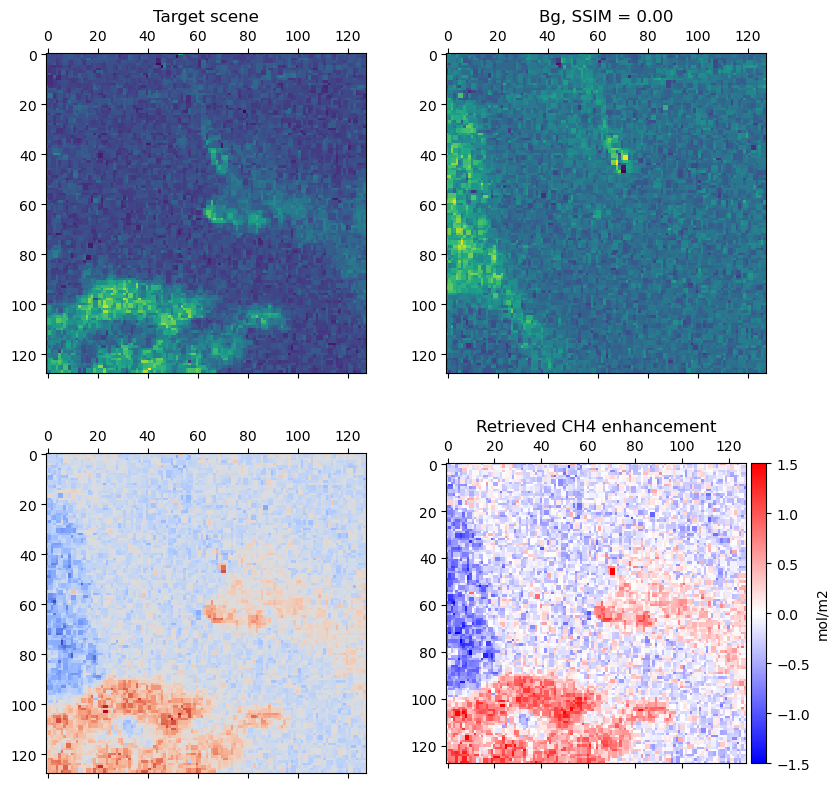

In [238]:
start_time = datetime(2008, 9, 27, 0, 0)
end_time = datetime(2008, 9, 28, 0, 0)
lonnow = 54.198
latnow = 38.494
img_id_list, date_list, img_date_list, imgchannels, imgxch4, imglons, imglats, u10m, v10m = get_plume(lonnow, 
                                                                                                      latnow, 
                                                                                                      start_time.strftime('%Y-%m-%d'), 
                                                                                                      end_time.strftime('%Y-%m-%d'), 
                                                                                                      1.5, 1.5, 
                                                                                                      do_retrieval=False, 
                                                                                                      satellite='Landsat 5')
bg, drmbg, dr = find_bg(lonnow, latnow, img_date_list[0], imgchannels[0, :, :, 0])

plt.figure(figsize=(8, 8))
ax = plt.subplot(221)
ax.matshow(dr)
ax.set_title('Target scene')

ax = plt.subplot(222)
ax.matshow(bg)
ax.set_title('Bg, SSIM = %.2f'%ssim(zstandard(bg), zstandard(dr)))
ax = plt.subplot(223)
ax.matshow(dr - bg, cmap='coolwarm')

num_layers = 100
targheight = 0
obsheight  = 100
solarangle = 40
obsangle   = 0
instrument = 'L4'
method     = 'MBSP'
ch4 = -rt.retrieve(dr, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)
ch4bg = -rt.retrieve(bg, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)

ax = plt.subplot(224)
im = ax.matshow(ch4-ch4bg, cmap='bwr', vmin=-1.5, vmax=1.5)
# plt.colorbar(im, orientation='horizontal', label='mol/m2')
ax.set_title('Retrieved CH4 enhancement')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical', label='mol/m2')

plt.subplots_adjust(hspace=0.25, wspace=0.25, top=0.95, bottom=0.05, right=0.95, left=0.05)

1998-08-22 00:00:00
1998-02-23 06:45:27.171000 1999-02-18 06:45:27.171000
<class 'numpy.ndarray'>
1998-08-22 00:00:00 [datetime.datetime(1998, 3, 8, 0, 0) datetime.datetime(1998, 3, 24, 0, 0)
 datetime.datetime(1998, 4, 9, 0, 0) datetime.datetime(1998, 4, 25, 0, 0)
 datetime.datetime(1998, 5, 11, 0, 0) datetime.datetime(1998, 6, 12, 0, 0)
 datetime.datetime(1998, 6, 28, 0, 0) datetime.datetime(1998, 7, 14, 0, 0)
 datetime.datetime(1998, 8, 15, 0, 0) datetime.datetime(1998, 8, 31, 0, 0)
 datetime.datetime(1998, 9, 16, 0, 0) datetime.datetime(1998, 10, 2, 0, 0)
 datetime.datetime(1998, 10, 18, 0, 0)
 datetime.datetime(1998, 11, 3, 0, 0)
 datetime.datetime(1998, 11, 19, 0, 0)
 datetime.datetime(1998, 12, 5, 0, 0)
 datetime.datetime(1998, 12, 21, 0, 0) datetime.datetime(1999, 1, 6, 0, 0)
 datetime.datetime(1999, 1, 22, 0, 0) datetime.datetime(1999, 2, 7, 0, 0)
 datetime.datetime(1998, 3, 15, 0, 0) datetime.datetime(1998, 3, 31, 0, 0)
 datetime.datetime(1998, 4, 16, 0, 0) datetime.datetime(

Text(0.5, 0.98, '[Lon: 53.744, Lat: 39.473, 1998-08-22]')

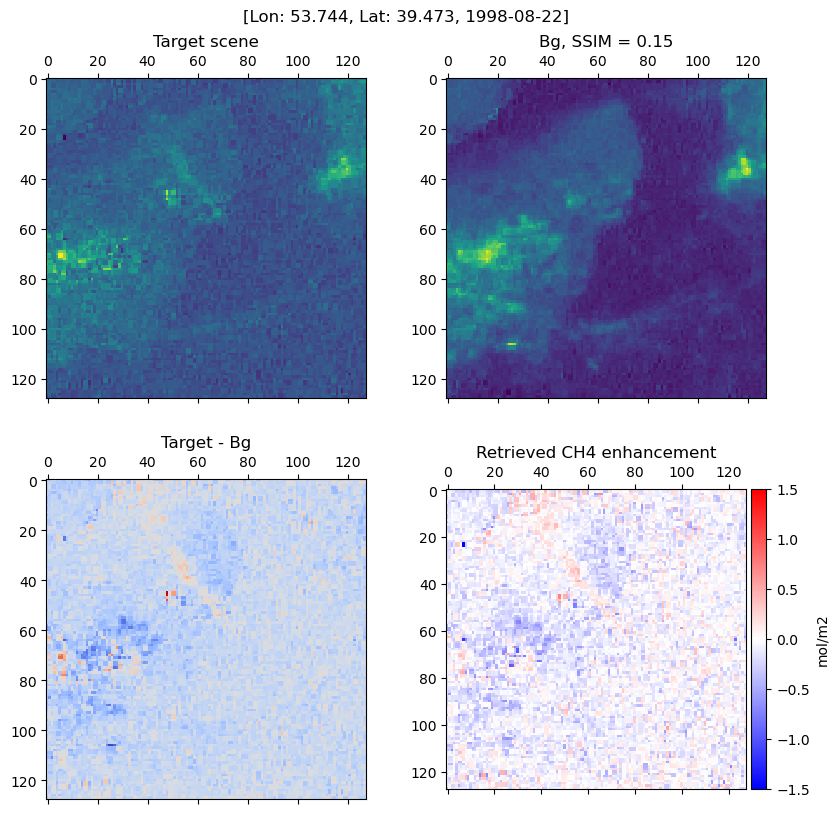

In [307]:
start_time = datetime(1998, 8, 22, 0, 0) # 1989-2-8, 1989-7-2, 
end_time = start_time + timedelta(days=1)
lonnow = 53.744
latnow = 39.473
img_id_list, date_list, img_date_list, imgchannels, imgxch4, imglons, imglats, u10m, v10m = get_plume(lonnow, 
                                                                                                      latnow, 
                                                                                                      start_time.strftime('%Y-%m-%d'), 
                                                                                                      end_time.strftime('%Y-%m-%d'), 
                                                                                                      1.5, 1.5, 
                                                                                                      do_retrieval=False, 
                                                                                                      satellite='Landsat 5')
bg, drmbg, dr = find_bg(lonnow, latnow, img_date_list[0], imgchannels[0, :, :, 0])

plt.figure(figsize=(8, 8.5))
ax = plt.subplot(221)
ax.matshow(dr)
ax.set_title('Target scene')

ax = plt.subplot(222)
ax.matshow(bg)
ax.set_title('Bg, SSIM = %.2f'%ssim(zstandard(bg), zstandard(dr)))
ax = plt.subplot(223)
im = ax.matshow(dr - bg, cmap='coolwarm')
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax, orientation='vertical', label='mol/m2')
ax.set_title('Target - Bg')

num_layers = 100
targheight = 0
obsheight  = 100
solarangle = 40
obsangle   = 0
instrument = 'L4'
method     = 'MBSP'
ch4 = -rt.retrieve(dr, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)
ch4bg = -rt.retrieve(bg, instrument, method, targheight, obsheight, solarangle, obsangle, num_layers=num_layers)

ax = plt.subplot(224)
im = ax.matshow(ch4-ch4bg, cmap='bwr', vmin=-1.5, vmax=1.5)
# plt.colorbar(im, orientation='horizontal', label='mol/m2')
ax.set_title('Retrieved CH4 enhancement')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, orientation='vertical', label='mol/m2')

plt.subplots_adjust(hspace=0.25, wspace=0.25, top=0.9, bottom=0.05, right=0.95, left=0.05)
plt.suptitle('[Lon: %.3f, Lat: %.3f, %s]'%(lonnow, latnow, start_time.strftime('%Y-%m-%d')))

# plt.savefig('landsat3.png', dpi=200)

---